Vamos a cargar el dataset de AirBnB

In [1]:
airbnb<-read.csv('airbnb-listings.csv',sep = ';')
options(repr.plot.height=4,repr.plot.width=6,repr.plot.res = 300)

Vamos a quedarnos con las columnas de mayor interés y convertimos de Square.Feet a Square.Meters (1 foot=0.092903m²):

In [2]:
library(tidyverse)

df_airbnb <- airbnb %>% 
select(c('City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds',
               'Price','Square.Feet',
                'Guests.Included','Extra.People',
               'Review.Scores.Rating','Latitude', 'Longitude')) %>% 
mutate(Square.Meters=Square.Feet*0.092903) %>%
select(-c("Square.Feet"))

#Lo mismo pero con R básico:
#df_airbnb<-airbnb[,c('City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds',
#               'Price','Square.Feet',
#                'Guests.Included','Extra.People',
#               'Review.Scores.Rating','Latitude', 'Longitude')]
#df_airbnb$Square.Meters<-df_airbnb$Square.Feet*0.092903

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  3.0.1     ✔ dplyr   0.8.4
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Nos quedarmos solo con las entradas de Madrid para Room.Type=="Entire home/apt" y cuyo barrio (Neighbourhood) no está vacio ''
Podemos eliminar las siguientes columnas que ya no son necesarias:
"Room.Type",'City'

Llama a nuevo dataframe df_madrid.

In [3]:
library(tidyverse)
df_madrid<-df_airbnb %>% 
    filter(Room.Type=="Entire home/apt" & City=='Madrid' & Neighbourhood!='') %>% 
    select(-c("Room.Type",'City')) %>%
    droplevels()

set.seed(123)

In [4]:
summary(df_madrid)

     Neighbourhood   Accommodates      Bathrooms        Bedrooms     
 Malasaña   : 679   Min.   : 1.000   Min.   :0.000   Min.   : 0.000  
 Embajadores: 585   1st Qu.: 3.000   1st Qu.:1.000   1st Qu.: 1.000  
 La Latina  : 571   Median : 4.000   Median :1.000   Median : 1.000  
 Sol        : 536   Mean   : 4.101   Mean   :1.248   Mean   : 1.453  
 Cortes     : 441   3rd Qu.: 5.000   3rd Qu.:1.000   3rd Qu.: 2.000  
 Justicia   : 384   Max.   :16.000   Max.   :6.500   Max.   :10.000  
 (Other)    :2405                    NA's   :14      NA's   :7       
      Beds            Price        Guests.Included   Extra.People   
 Min.   : 1.000   Min.   : 10.00   Min.   : 1.000   Min.   :  0.00  
 1st Qu.: 1.000   1st Qu.: 56.00   1st Qu.: 1.000   1st Qu.:  0.00  
 Median : 2.000   Median : 75.00   Median : 2.000   Median : 10.00  
 Mean   : 2.393   Mean   : 88.74   Mean   : 1.952   Mean   :  8.79  
 3rd Qu.: 3.000   3rd Qu.:100.00   3rd Qu.: 2.000   3rd Qu.: 15.00  
 Max.   :16.000   Max.   :

¿Que porcentaje de los apartamentos no muestran los metros cuadrados? Es decir que tienen NA en Square.Meters

In [5]:
paste0("El porcentaje de NAs es: ",sum(is.na(df_madrid$Square.Meters)/nrow(df_madrid))*100,"%")

[1] "El porcentaje de NAs es: 93.8046777361185%"

De todos los apartamentos que tienen un valor de metros cuadrados diferente de NA 
¿Que porcentaje de los apartamentos tienen 0 metros cuadrados?

In [6]:
paste0("El porcentaje de NAs es: ",sum(df_madrid$Square.Meters==0,na.rm=T)/sum(!is.na(df_madrid$Square.Meters))*100,"%")

[1] "El porcentaje de NAs es: 36.8876080691643%"

Reemplazar todos los 0m^2 por NA 

In [7]:
df_madrid<-df_madrid %>% mutate(Square.Meters = ifelse(Square.Meters==0, NA, Square.Meters))

Son muchos, vamos a intentar crear un modelo que nos prediga cuantos son los metros cuadrados en función del resto de variables para tratar de rellenar esos NA.

Antes de eso deberíamos pintar el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más.

Warning message:
“Removed 5382 rows containing non-finite values (stat_bin).”


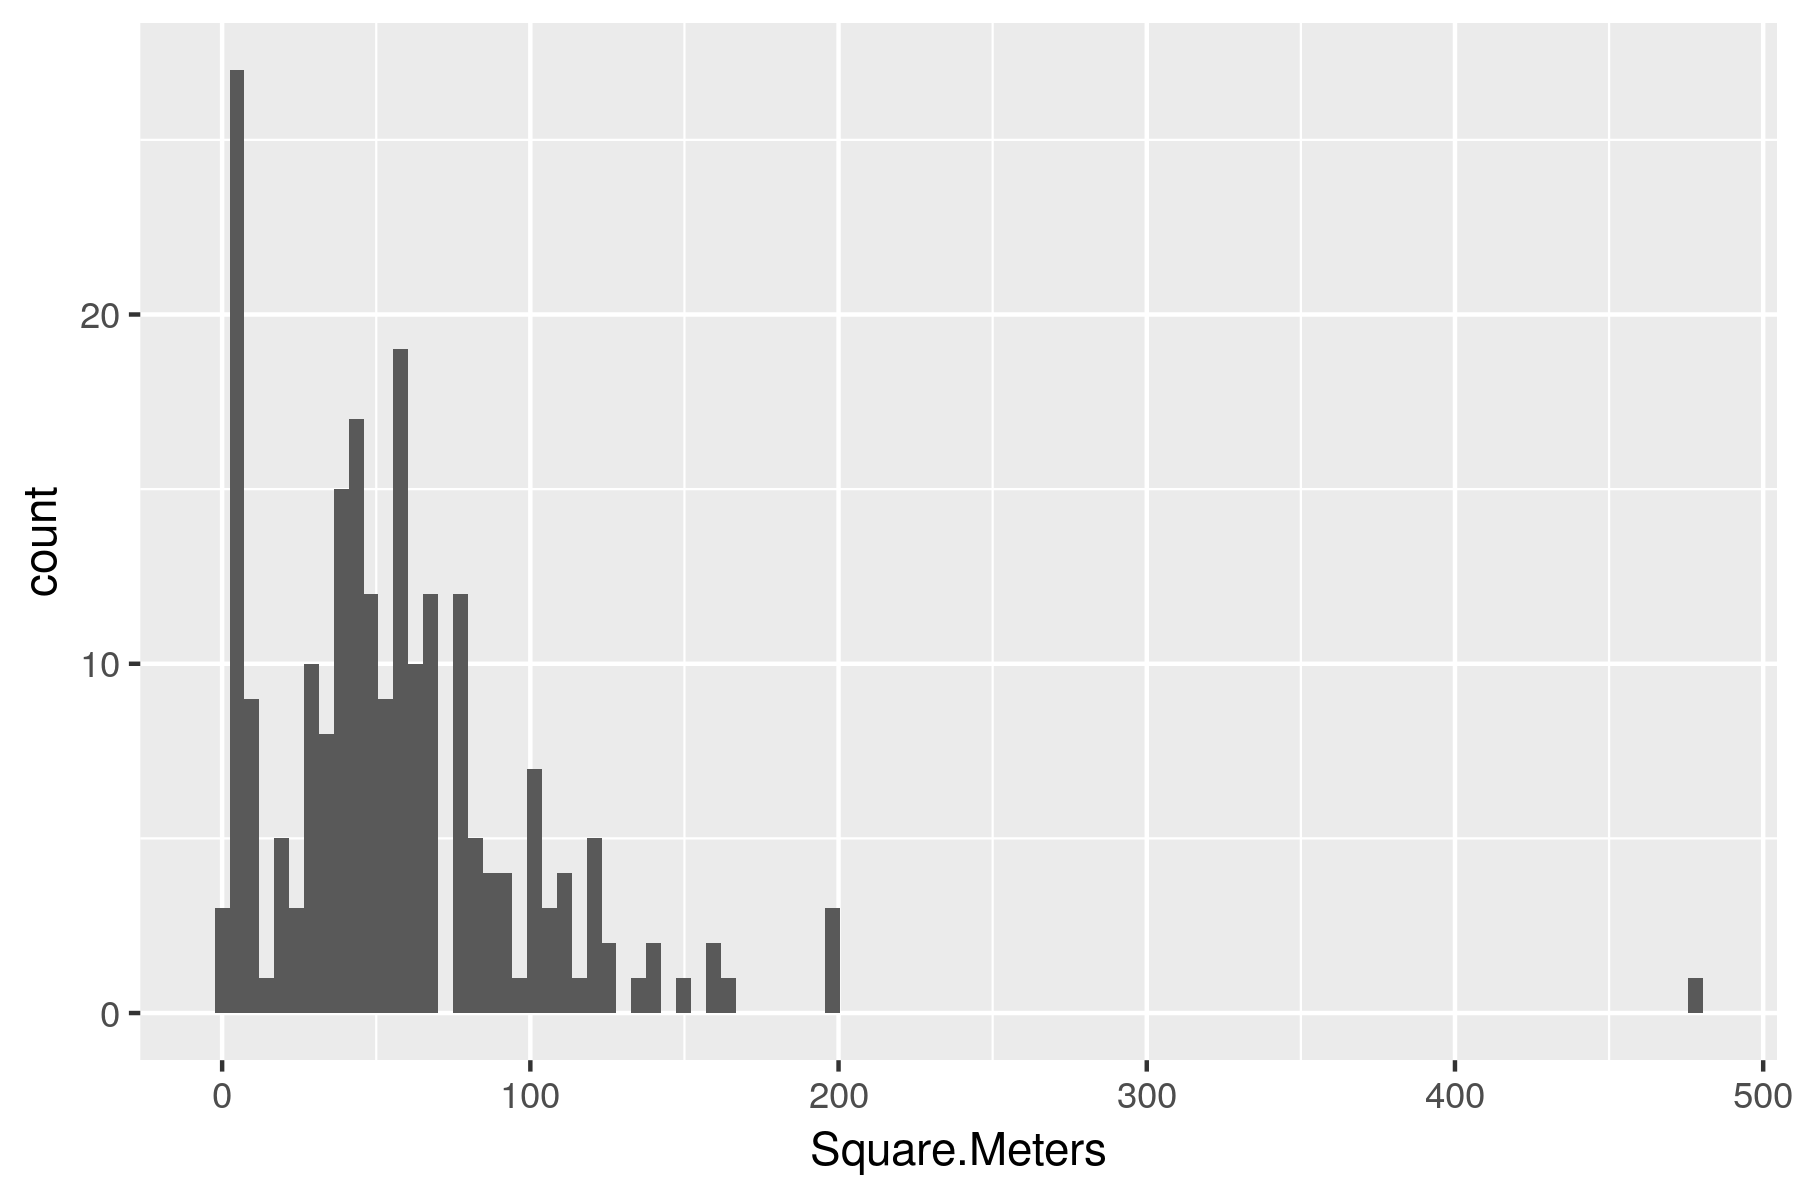

In [8]:
df_madrid %>% ggplot(aes(x=Square.Meters))+geom_histogram(bins=100)

In [9]:
df_madrid %>% filter(Square.Meters<10)

# Existen muchos apartamentos con 0 m^2 y 
# hay algunos que tienen varias habitaciones y dicen que tienen menos de 20m^2


Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters
<fct>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
Justicia,2,1.0,1,1,88,2,11,88,40.42108,-3.697730,5.109665
Cortes,6,2.0,2,1,108,2,11,86,40.41133,-3.695197,8.361270
Cortes,2,2.0,1,1,60,2,15,81,40.41403,-3.701206,3.994829
Sol,6,2.0,2,3,90,1,0,100,40.41790,-3.708193,9.290300
Adelfas,4,2.0,2,2,76,4,15,75,40.40606,-3.668898,7.432240
Malasaña,6,1.5,3,1,119,2,11,47,40.42395,-3.705095,6.967725
Estrella,2,1.0,1,2,50,1,0,88,40.40940,-3.665227,2.043866
Malasaña,4,1.0,1,1,81,2,11,83,40.42408,-3.703804,3.716120
La Latina,6,2.0,2,4,118,2,11,85,40.41118,-3.709628,7.896755


Asigna el valor NA a la columna Square.Meters de los apartamentos que tengan menos de 20 m^2

In [10]:
df_madrid<-df_madrid %>% mutate(Square.Meters = ifelse(Square.Meters<20, NA, Square.Meters))
# Esa línea es equivalente a:
#df_madrid[,df_madrid$Square.Meters<20]<-NA

El barrio parece ser un indicador importante para los metros cuadrados de un apartamento.

Vamos a agrupar los barrios por metros cuadrados. Podemos usar una matriz de similaridad de Tukey tal y como hicimos en el curso de estadística:

Warning message in resm[lower.tri(resm)] <- round(tky.result$p.adj, 4):
“number of items to replace is not a multiple of replacement length”

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




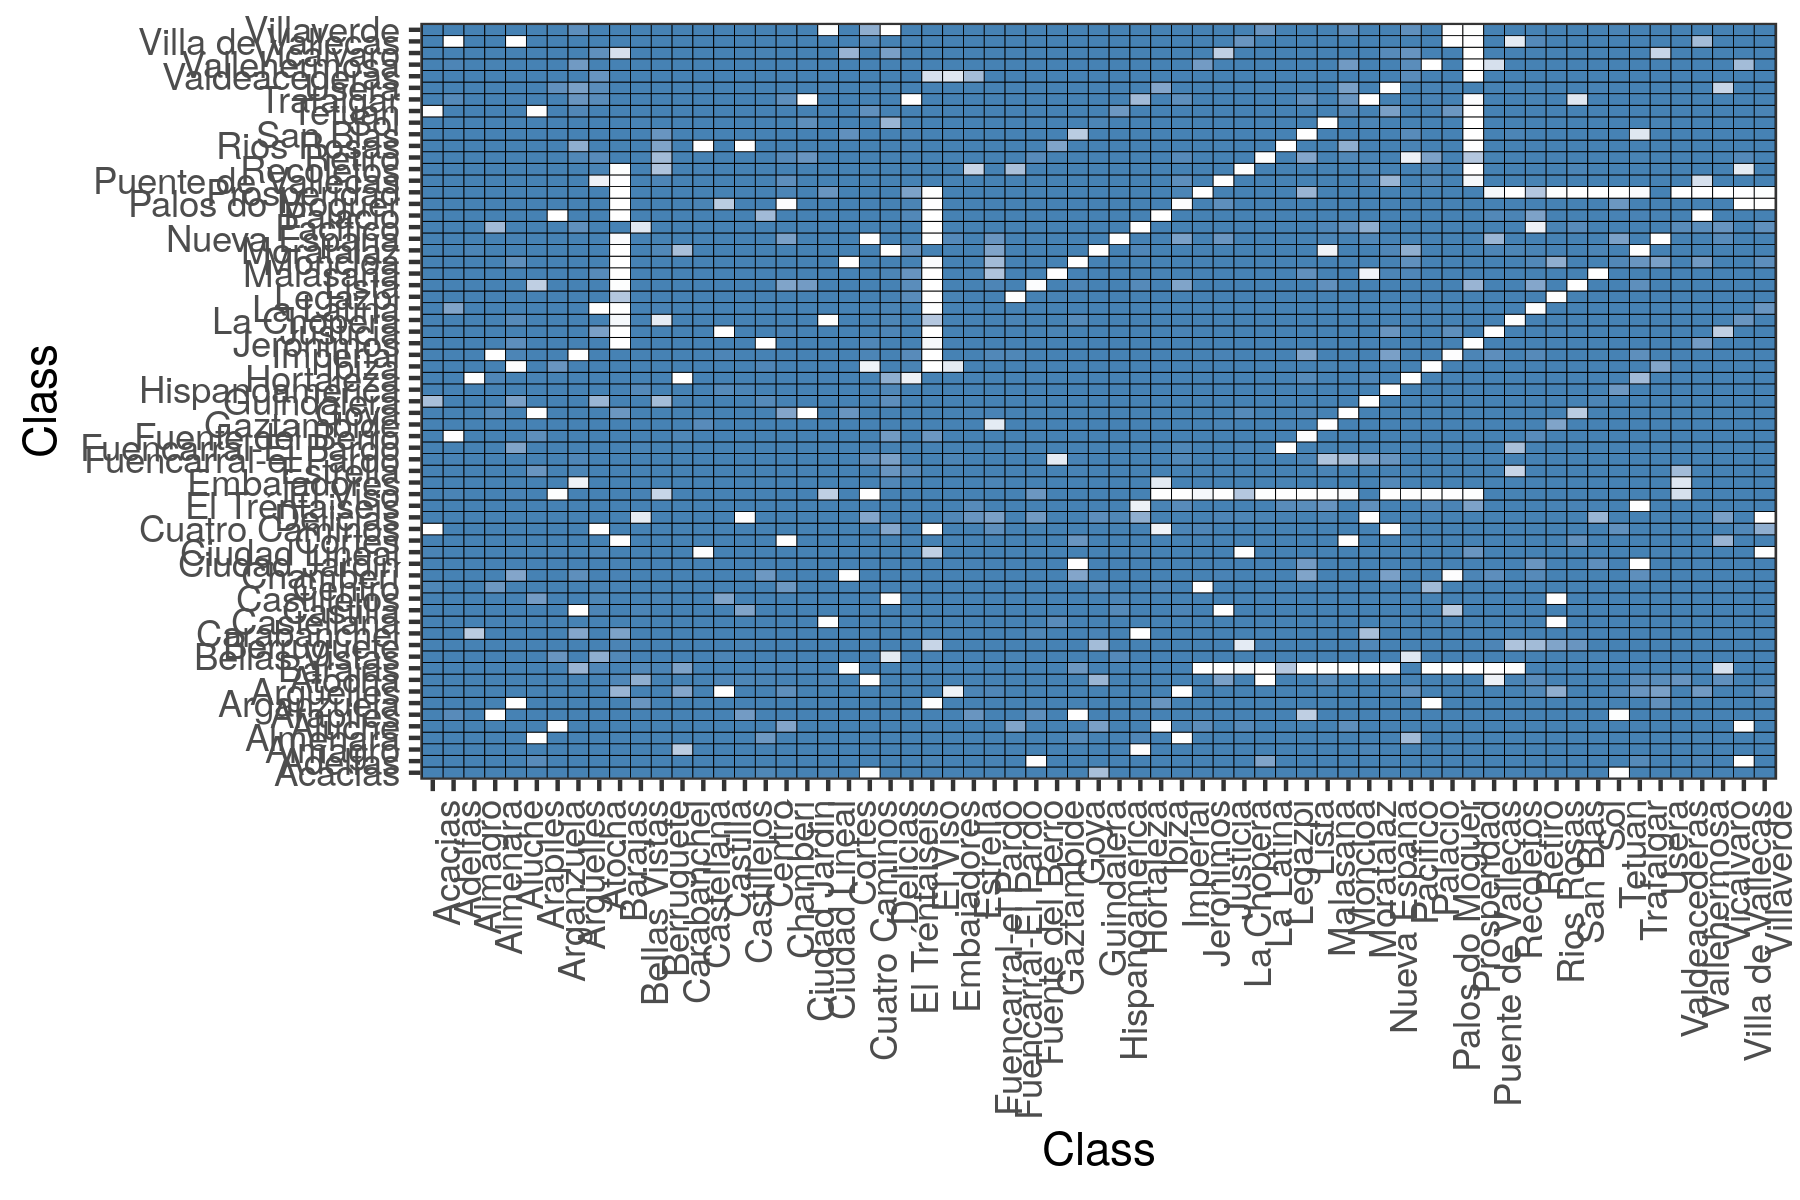

In [11]:
tky<-TukeyHSD(aov( formula=Square.Meters~Neighbourhood, data=df_madrid ))
tky.result<-data.frame(tky$Neighbourhood)
cn <-sort(unique(df_madrid$Neighbourhood))
resm <- matrix(NA, length(cn),length(cn))
rownames(resm) <- cn
colnames(resm) <- cn
resm[lower.tri(resm) ] <- round(tky.result$p.adj,4)
resm[upper.tri(resm) ] <- t(resm)[upper.tri(resm)] 
diag(resm) <- 1
library(ggplot2)
library(reshape2)
dfResm <- melt(resm)
ggplot(dfResm, aes(x=Var1, y=Var2, fill=value))+
  geom_tile(colour = "black")+
  scale_fill_gradient(low = "white",high = "steelblue")+
  ylab("Class")+xlab("Class")+theme_bw()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position="none")

Usando como variable de distancia: 1-resm
Dibuja un dendrograma de los diferentes barrios.


In [12]:
f_dist<-as.dist(1-resm)
hc <- hclust(f_dist,method="complete")
hcd <- as.dendrogram(hc)

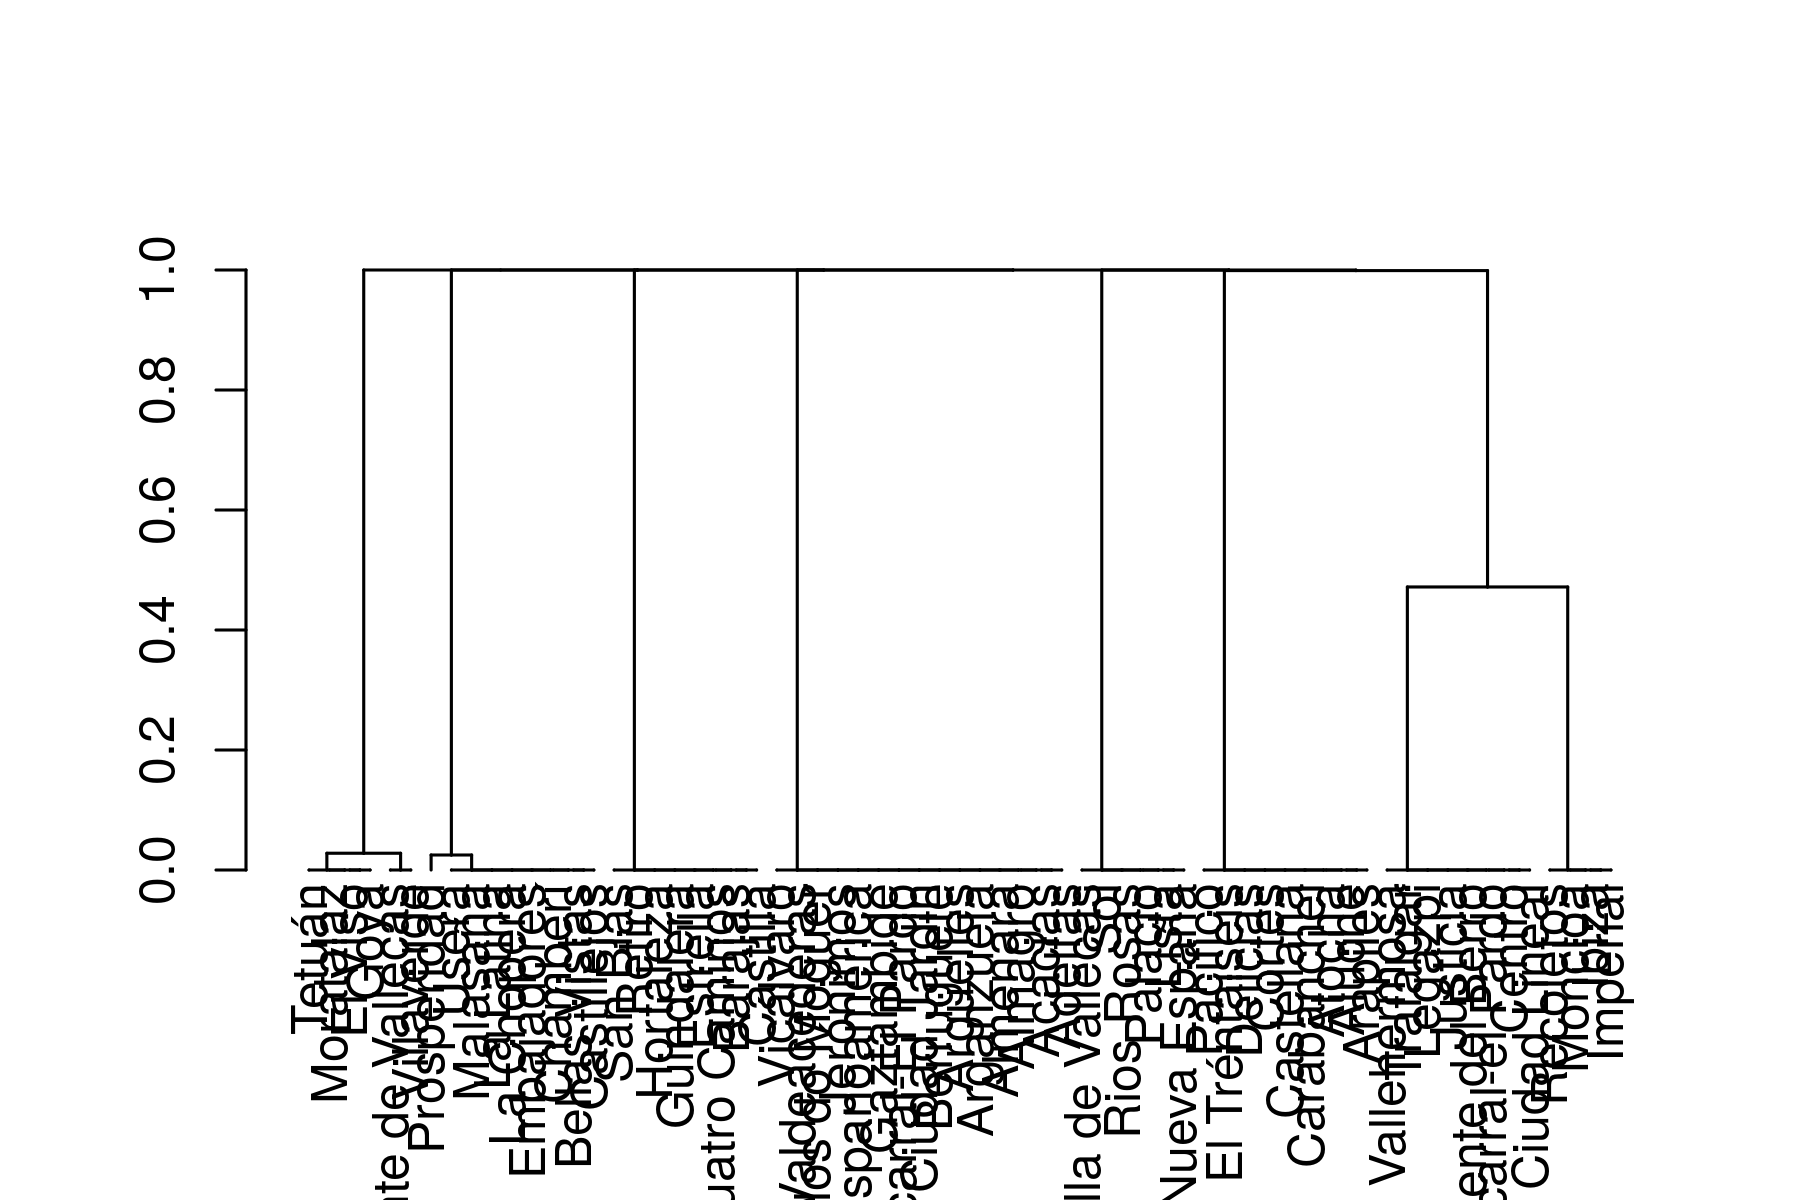

In [13]:
plot(hcd)

Estableciendo un punto de corte en 0.9, ¿cuantos clusters aparecen?

In [14]:
ct<-cutree(hc,h=0.9)

[1] "Vemos como en el modelo los clusters en general son buenos."


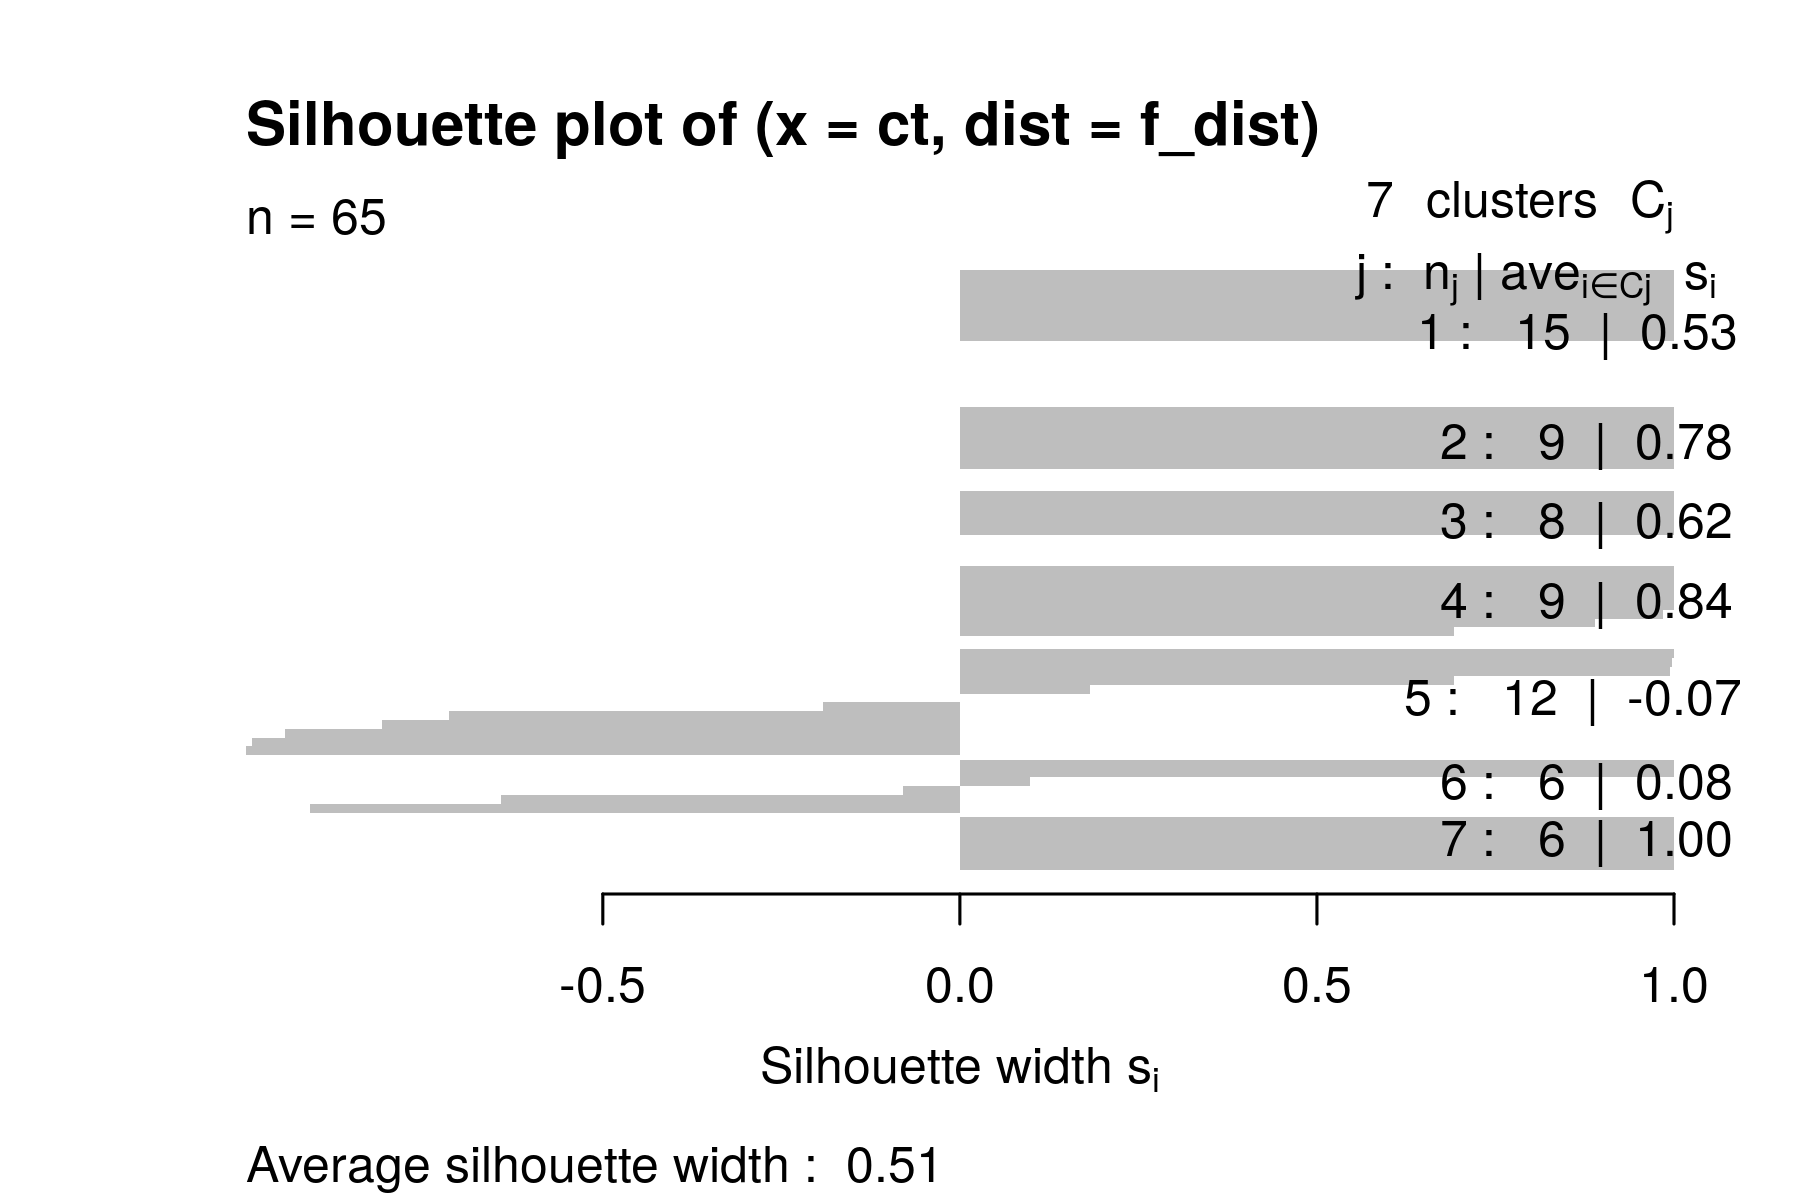

In [15]:
print("Vemos como en el modelo los clusters en general son buenos.")
library(cluster)
sil<-silhouette(ct,f_dist)
plot(sil,border=NA)

Vamos a crear una nueva columna en el dataframe df_madrid con un nuevo identificador marcado por los clusters obtenidos. Esta columna la llamaremos neighb_id

In [16]:
df_barrios<-data.frame(names=names(ct),neighb_id=paste0("Neighb_id_",ct))
head(df_barrios)

,names,neighb_id
,<fct>,<fct>
1,Acacias,Neighb_id_1
2,Adelfas,Neighb_id_1
3,Almagro,Neighb_id_1
4,Almenara,Neighb_id_1
5,Aluche,Neighb_id_2
6,Arapiles,Neighb_id_2


In [17]:
df_madrid_id <- df_madrid %>% 
    inner_join(df_barrios,by=c("Neighbourhood"='names')) %>%
    filter(!is.na(Square.Meters))
# El inner join es equivalente a:
#df_madrid<-merge(df_madrid,df_barrios,by.x = "Neighbourhood",by.y='names')

dim(df_madrid_id) 
head(df_madrid_id)

[1] 174  13

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id
,<fct>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>
1,Embajadores,4,1.0,2,2,46,1,12,93,40.40912,-3.700638,44.03602,Neighb_id_4
2,Malasaña,2,1.0,1,1,74,1,0,97,40.42410,-3.700937,44.96505,Neighb_id_4
3,Malasaña,2,1.0,1,1,70,2,20,91,40.42159,-3.707741,79.98948,Neighb_id_4
4,Adelfas,6,1.5,2,6,60,2,15,94,40.39912,-3.670071,69.95596,Neighb_id_1
5,Goya,3,1.0,2,2,94,1,0,99,40.42774,-3.674565,90.02301,Neighb_id_6
6,Almagro,4,1.0,1,2,75,2,10,92,40.43825,-3.693876,49.98181,Neighb_id_1


Vamos a crear dos grupos, uno test y otro train.

Tratamos de predecir los metros cuadrados.

In [18]:
set.seed(12)
idx<-sample(1:nrow(df_madrid_id),nrow(df_madrid_id)*0.8)
df_madrid_id_train<-df_madrid_id[idx,]
df_madrid_id_test<-df_madrid_id[-idx,]

In [19]:
model<-lm(formula=Square.Meters~neighb_id+neighb_id+Price+Bedrooms, df_madrid_id_train)
#model<-lm(formula=Square.Meters~neighb_id+Bedrooms+Price:Accommodates, df_madrid_id_train) # Este modelo hace overfitting
#model<-lm(formula=Square.Meters~neighb_id+Bedrooms+Price, df_madrid_id_train)
summary(model)


Call:
lm(formula = Square.Meters ~ neighb_id + neighb_id + Price + 
    Bedrooms, data = df_madrid_id_train)

Residuals:
    Min      1Q  Median      3Q     Max 
-83.755 -13.117  -2.632  11.841 243.704 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           37.61084    8.62683   4.360 2.64e-05 ***
neighb_idNeighb_id_2 -31.21952   11.44487  -2.728 0.007264 ** 
neighb_idNeighb_id_3 -31.04924   13.76917  -2.255 0.025820 *  
neighb_idNeighb_id_4 -33.71697    8.76096  -3.849 0.000186 ***
neighb_idNeighb_id_5 -23.76863   11.44765  -2.076 0.039853 *  
neighb_idNeighb_id_6 -35.13515   17.74716  -1.980 0.049859 *  
neighb_idNeighb_id_7 -23.83093    9.92225  -2.402 0.017742 *  
Price                  0.16506    0.04429   3.727 0.000289 ***
Bedrooms              27.69334    3.34961   8.268 1.44e-13 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 31.55 on 129 degrees of freedom
  (1 observation deleted d

In [20]:
print("Comprobamos en el R² y otras medidas en train y test para ver si tenemos overfitting:")
caret::postResample(predict(model,df_madrid_id_train),obs = df_madrid_id_train$Square.Meters)
caret::postResample(predict(model,df_madrid_id_test),obs = df_madrid_id_test$Square.Meters)

[1] "Comprobamos en el R² y otras medidas en train y test para ver si tenemos overfitting:"


RMSE   Rsquared        MAE 
30.5004463  0.6216339 18.5746252

RMSE   Rsquared        MAE 
22.6933790  0.5020971 15.3498820

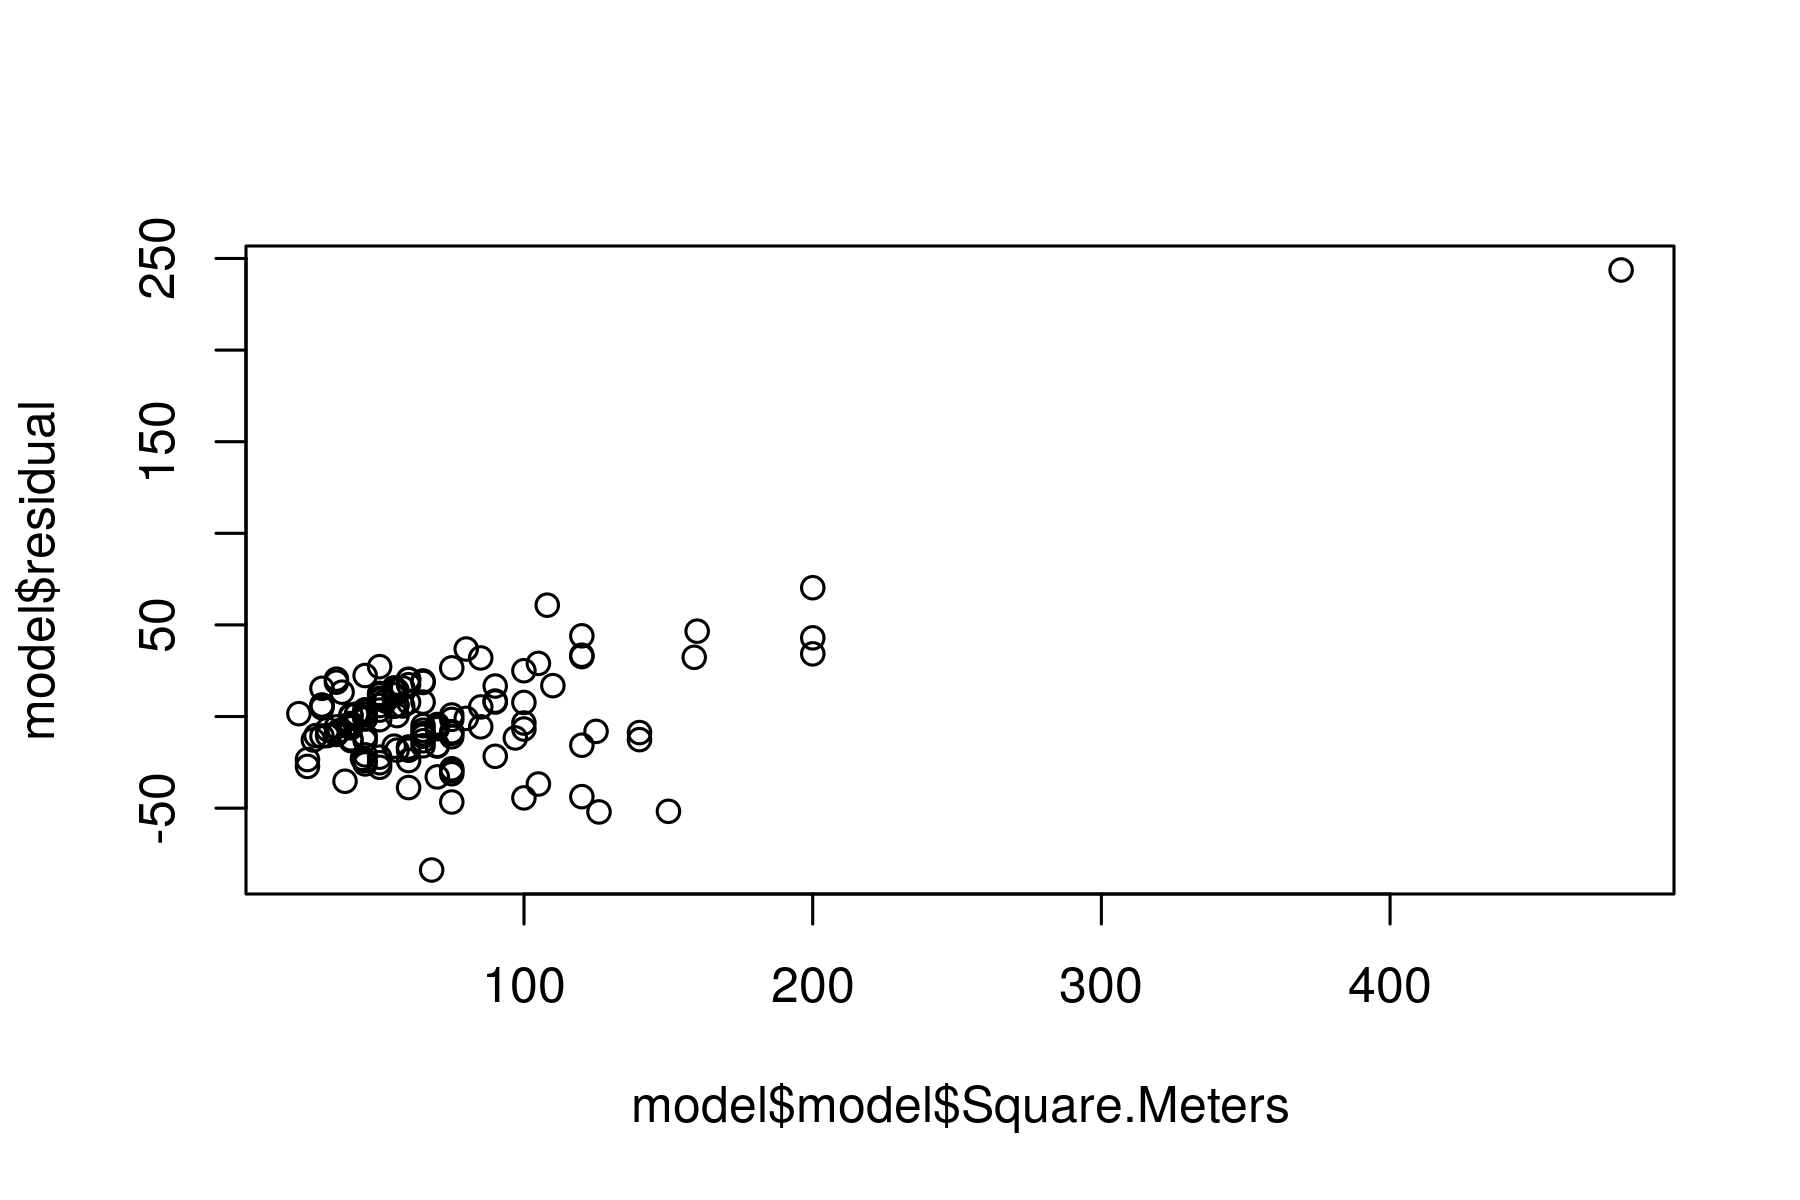

In [21]:
plot(model$model$Square.Meters,model$residual)
# Parece que tenemos un poco de heterocedasticidad, la varianza parece aumentar ligeramente, pero no es preocupante
# También vemos un outlier que podemos tratar.

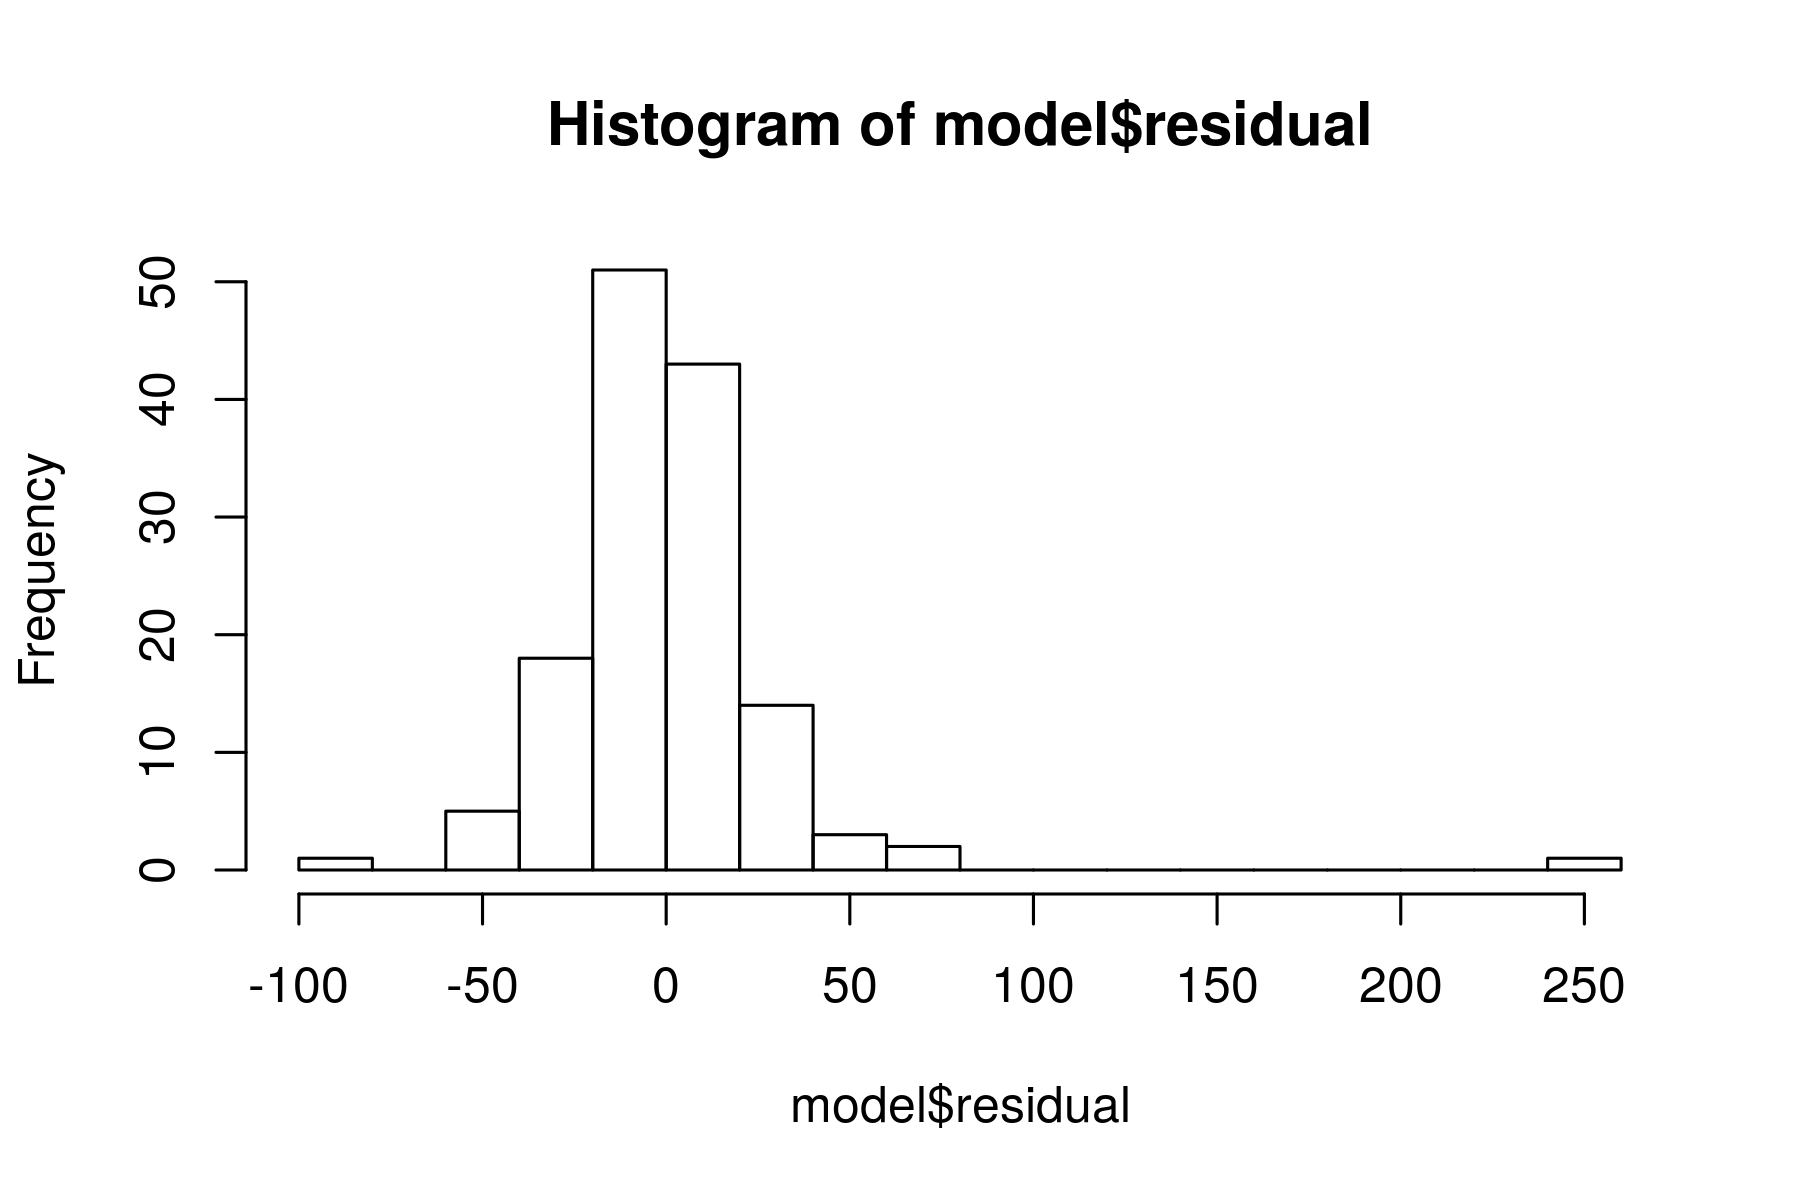

In [22]:
hist(model$residual,breaks=20)

[1] "Tenemos un elemento que tiene un residuo muy alto, ¿nos afectará a la predicción?"


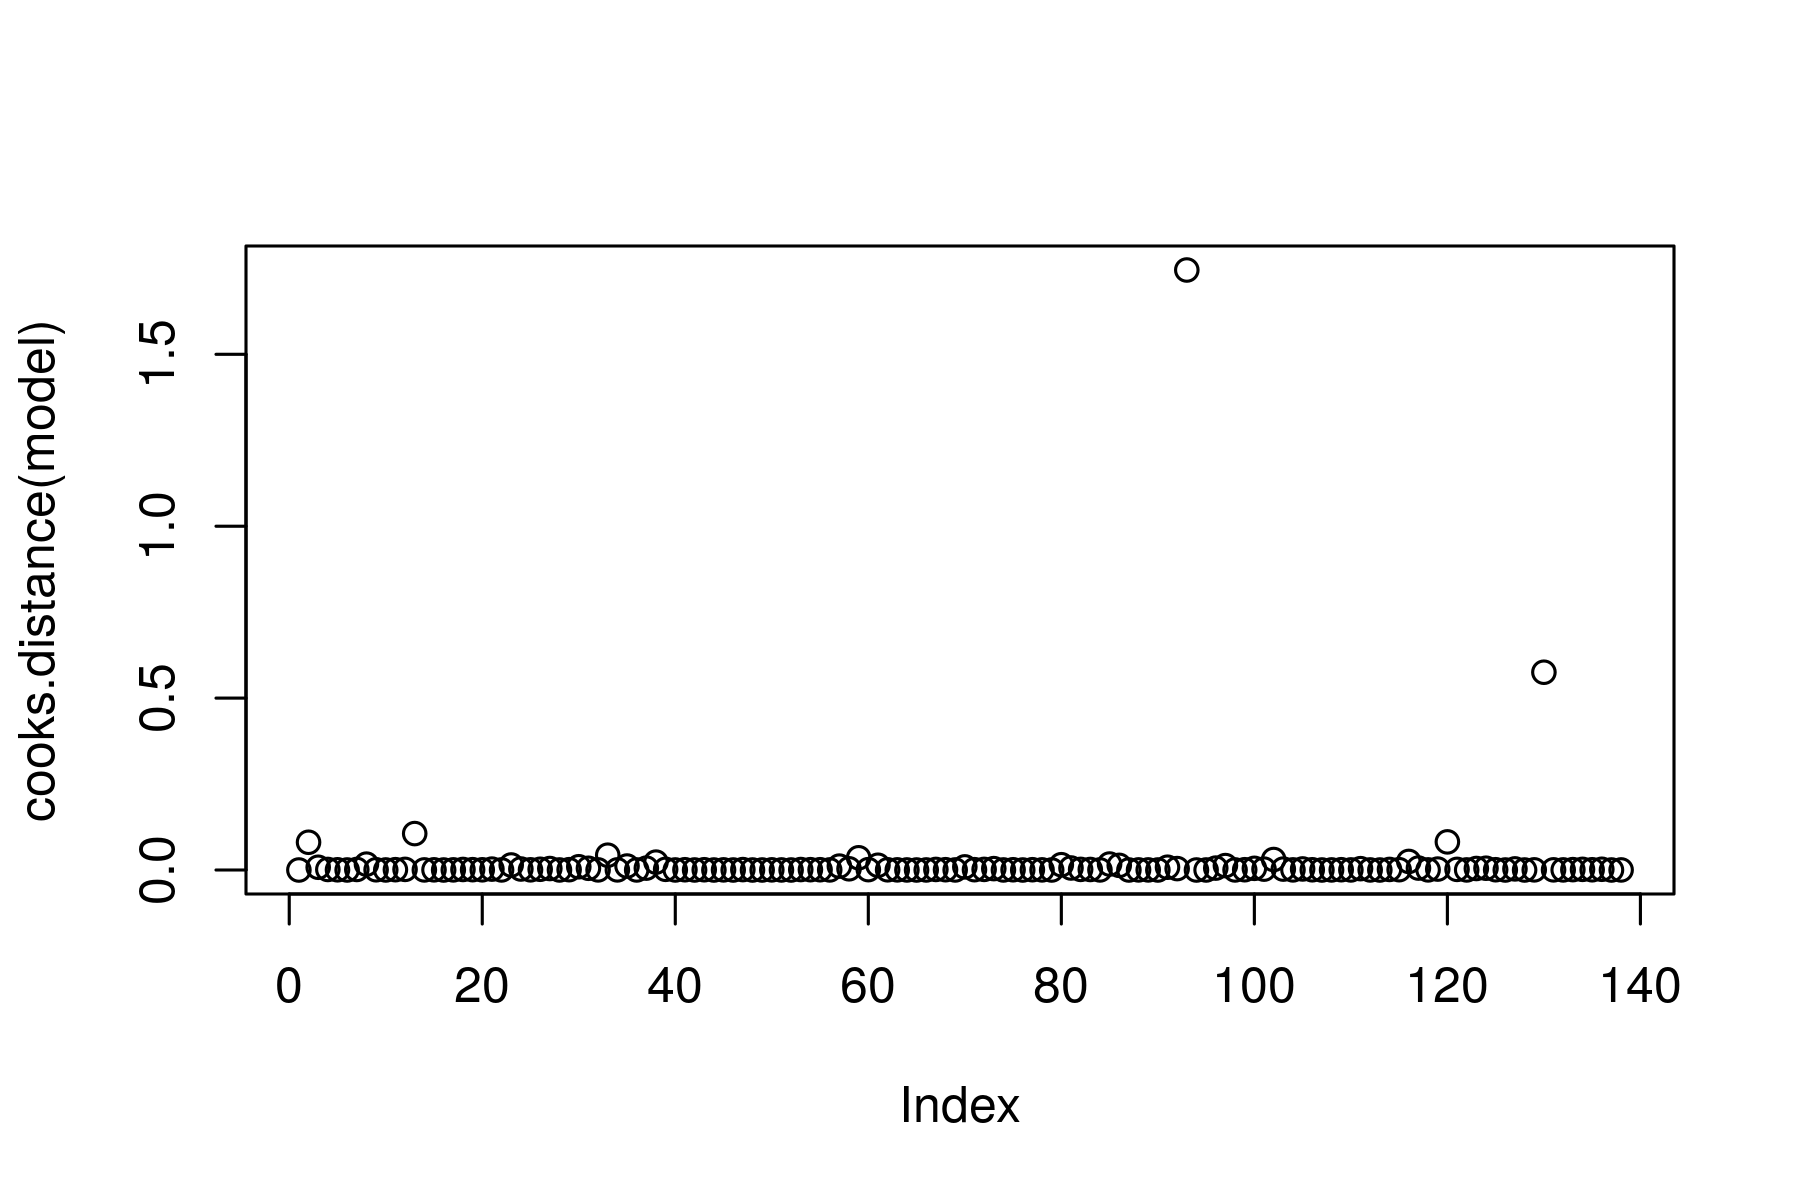

In [23]:
print("Tenemos un elemento que tiene un residuo muy alto, ¿nos afectará a la predicción?")
plot(cooks.distance(model))

In [24]:
cook_d<-cooks.distance(model)

df_madrid_id_train[names(cook_d),] %>% filter(cook_d>0.2)
# La línea anterior es equivalente a:
#df_madrid_id_train[names(which(cook_d>0.2)),]

Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id
<fct>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>
Jerónimos,16,5,5,13,365,5,37,98,40.41826,-3.690208,480.0298,Neighb_id_1
Justicia,6,1,2,6,500,4,15,93,40.42051,-3.699712,68.0050,Neighb_id_5


In [25]:
head(cook_d)

90           80           91           69           34          136 
3.967092e-06 8.070057e-02 7.959274e-03 1.557358e-03 6.116275e-04 7.224646e-05

In [26]:
# Aquí usamos como índice names(cook_d) porque los NAs no aparecen en la variable cook_d, por eso los indices no tienen porque coincidir
model_cook<-lm(formula=Square.Meters~neighb_id+Price+Bedrooms, df_madrid_id_train[names(cook_d),] %>% filter(cook_d<0.2))
print("Comprobamos en el R² y otras medidas en train y test para ver si tenemos overfitting:")
caret::postResample(predict(model_cook,df_madrid_id_train),obs = df_madrid_id_train$Square.Meters)
caret::postResample(predict(model_cook,df_madrid_id_test),obs = df_madrid_id_test$Square.Meters)

[1] "Comprobamos en el R² y otras medidas en train y test para ver si tenemos overfitting:"


RMSE   Rsquared        MAE 
31.9037468  0.6044469 16.9115007

RMSE   Rsquared        MAE 
20.4825049  0.4833111 14.7737917

Parece que no nos afectaba mucho al modelo, de hecho, parece que si filtramos por la distancia de cook de 0.2 en este caso nuestro modelo empeora muy ligeramente

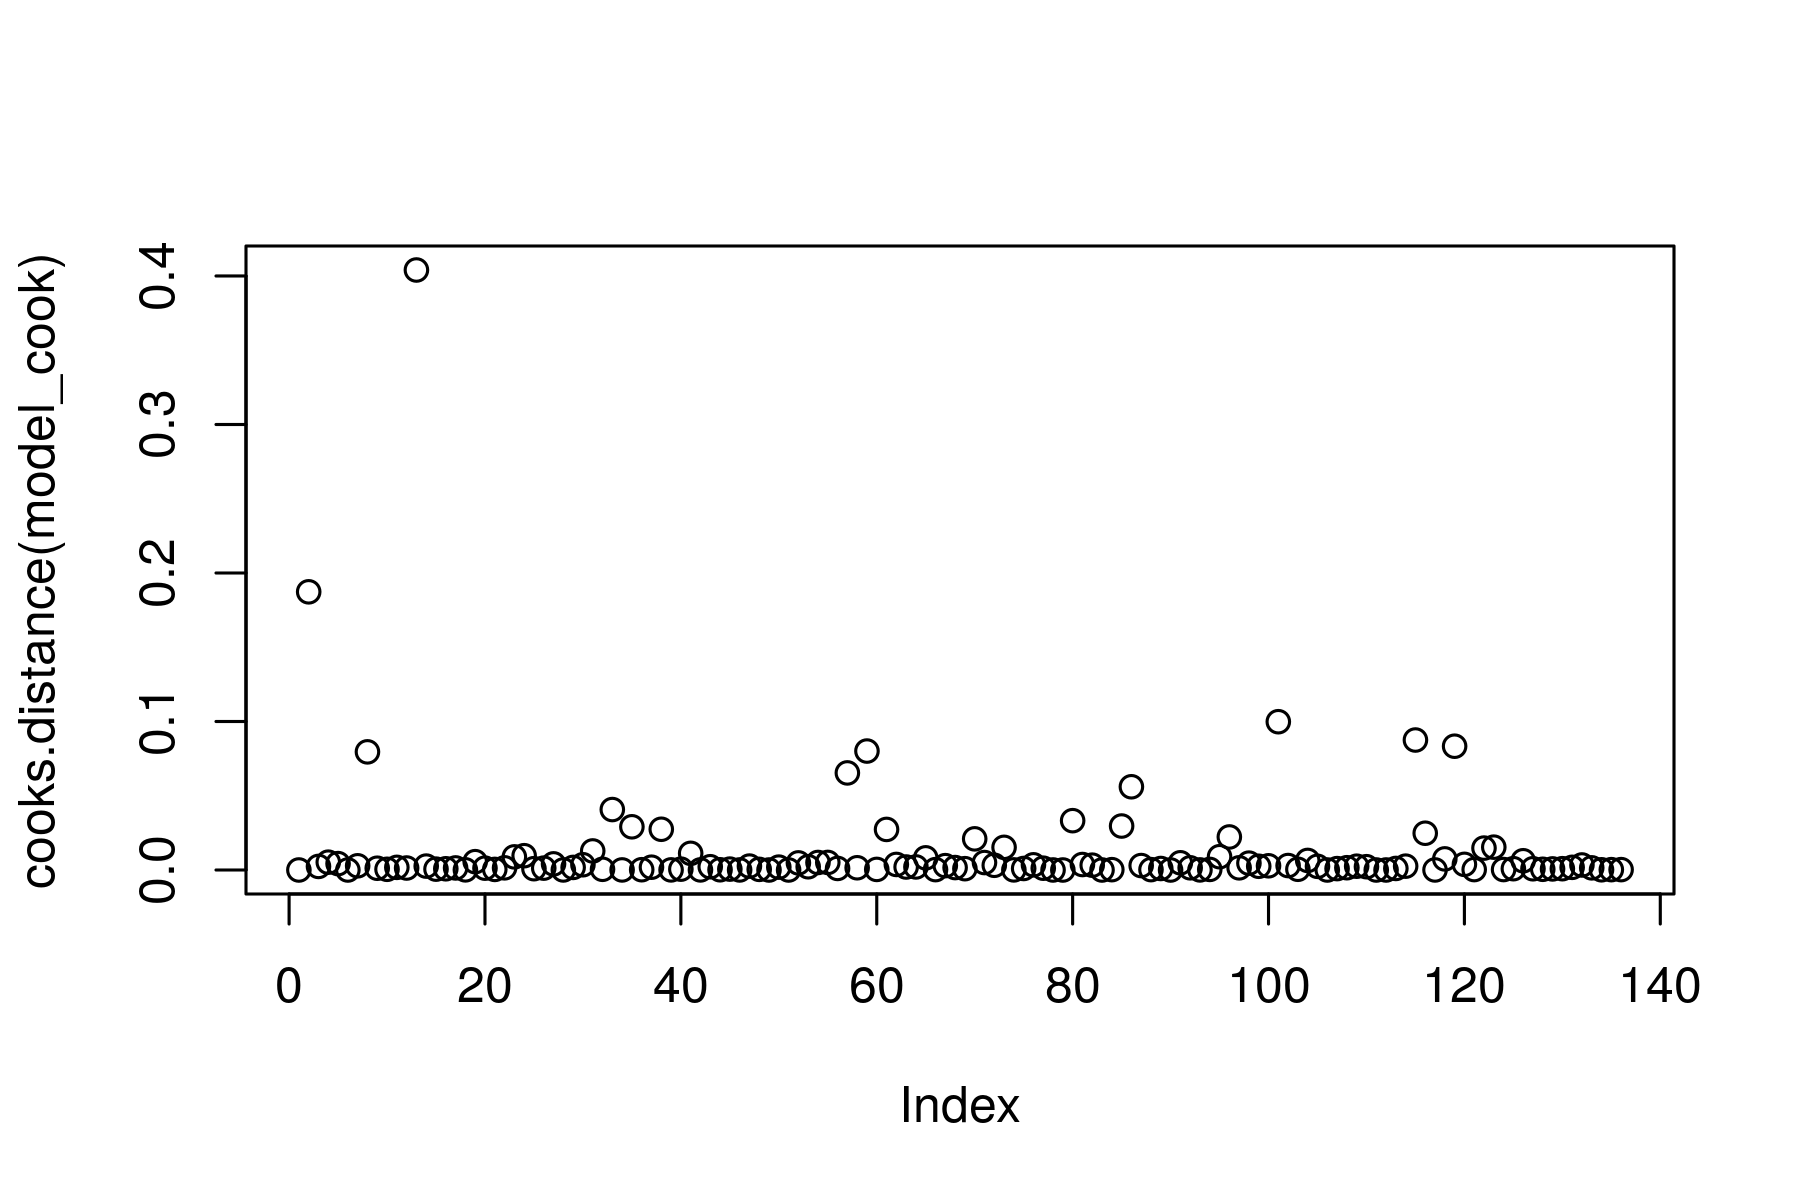

In [27]:
plot(cooks.distance(model_cook))

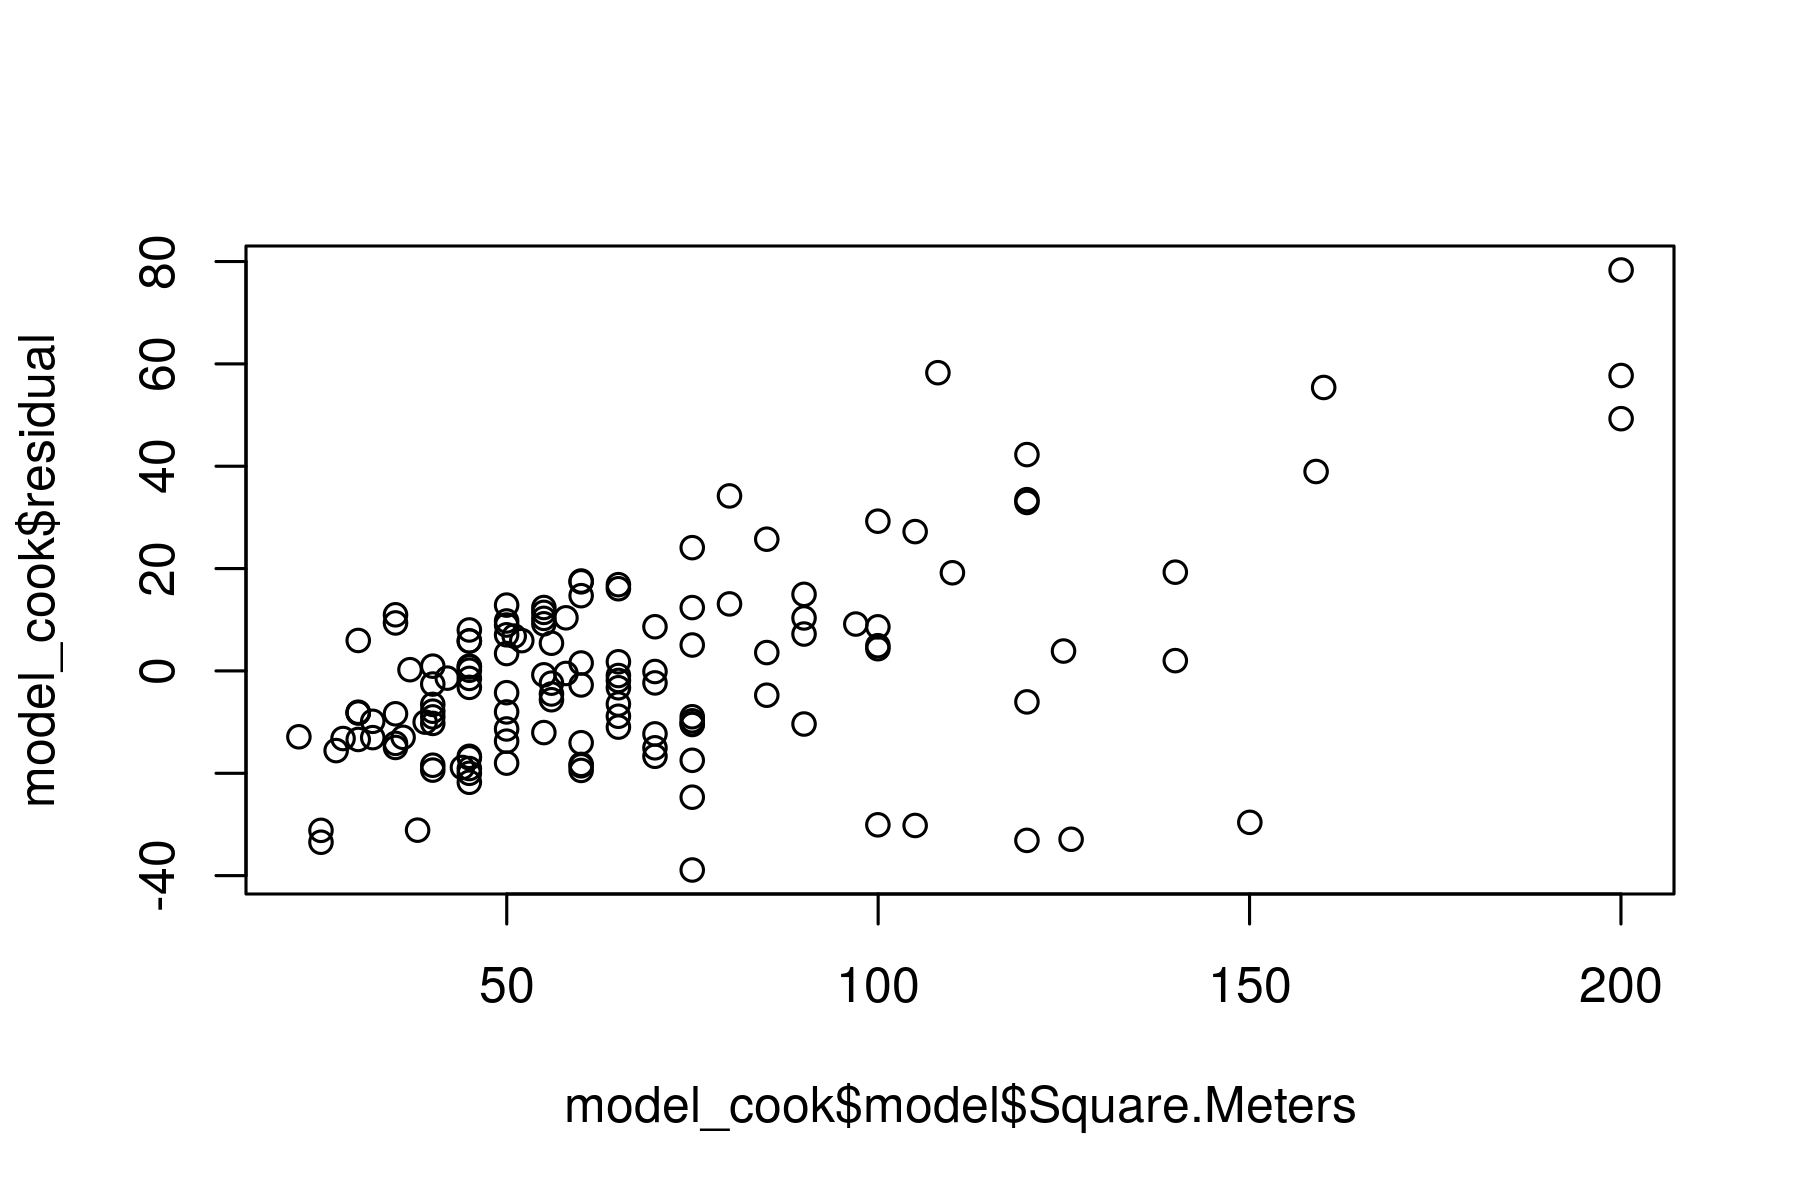

In [28]:
plot(model_cook$model$Square.Meters,model_cook$residual)

Vamos a probar con regularización por Ridge

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 3.0-2




[1] 631.0694

[1] 29.29165

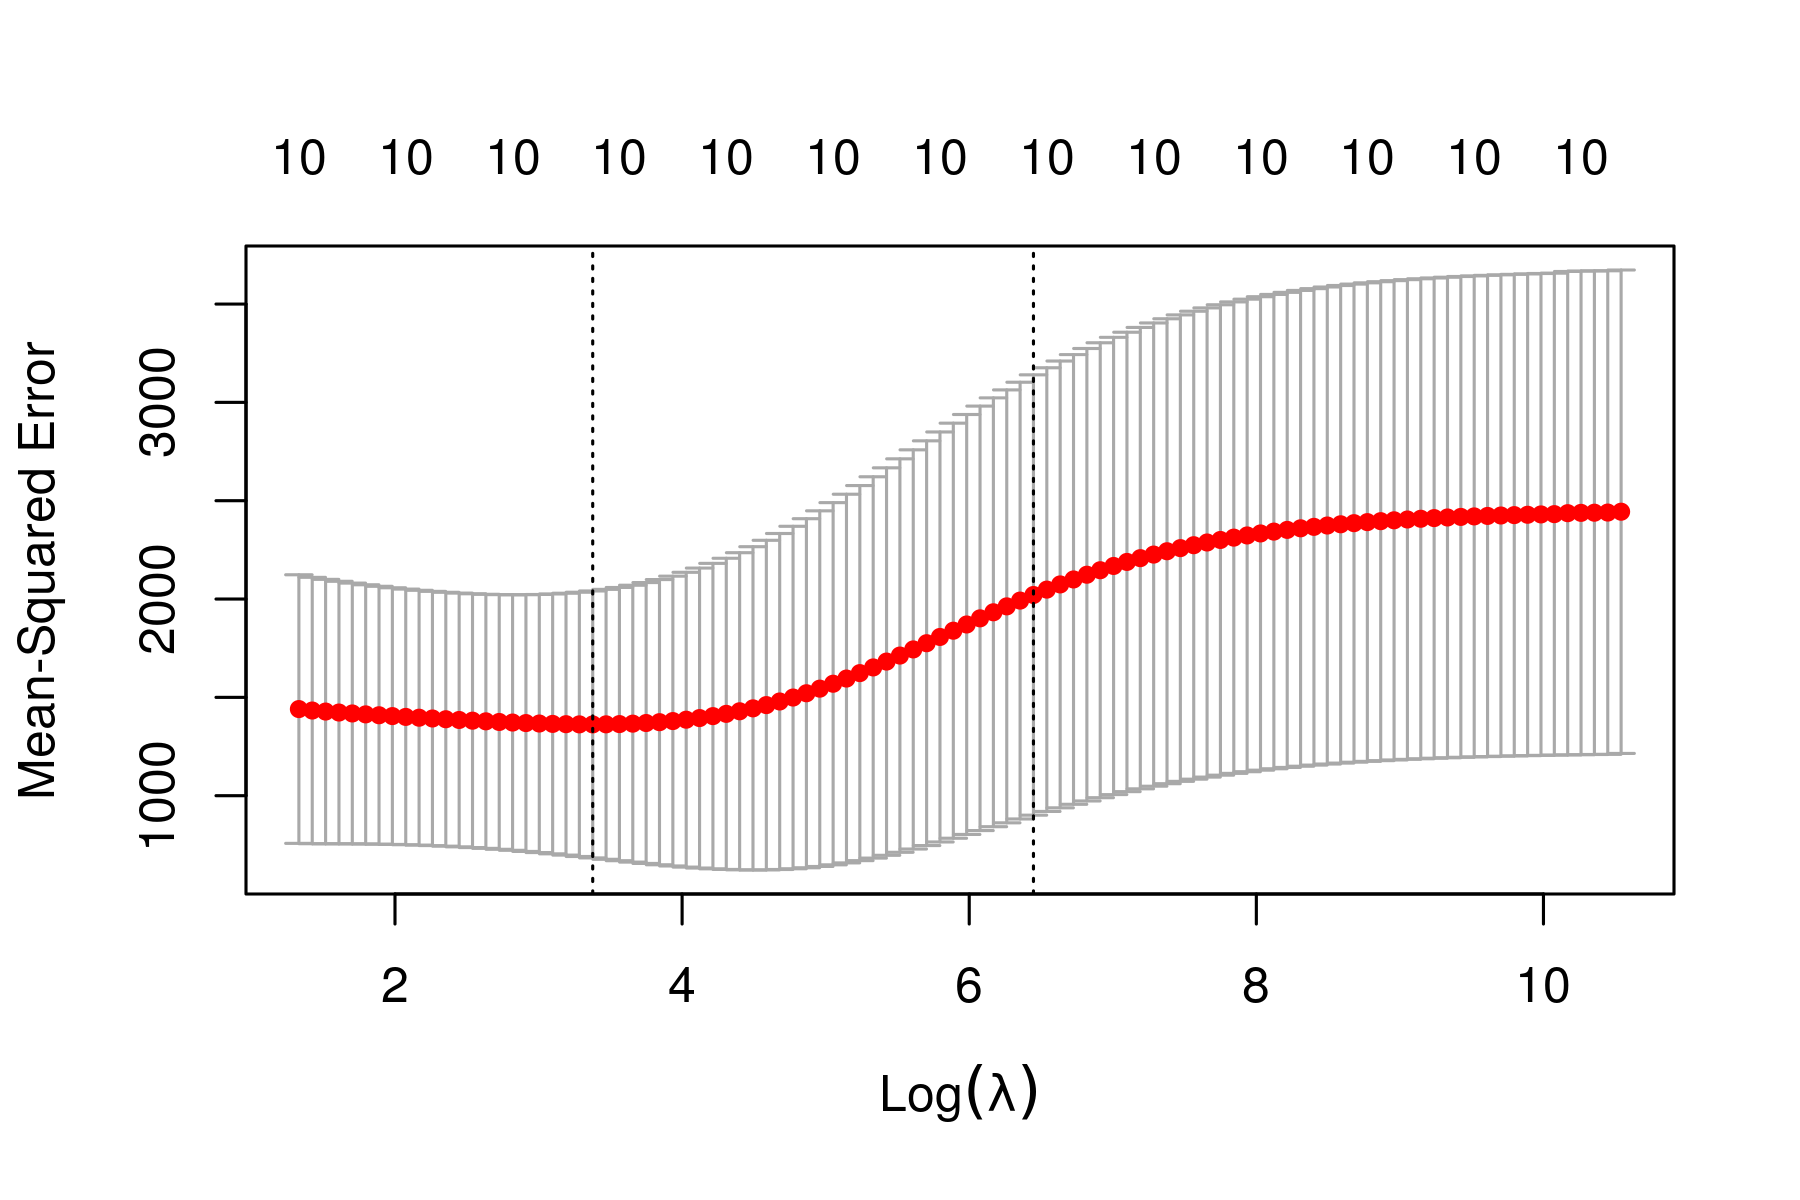

In [29]:
library(glmnet)
over_fit_model<-lm(formula=Square.Meters~neighb_id+Bedrooms+Price*Accommodates, df_madrid_id)
X<-model.matrix(over_fit_model)
y<-as.matrix(over_fit_model$model$Square.Meters,ncols=1)
set.seed(12)
idx<-sample(1:nrow(X),nrow(X)*0.8)
X_train<-X[idx,]
X_test<-X[-idx,]
y_train<-y[idx,]
y_test<-y[-idx,]

cvfit<-cv.glmnet(X_train,y_train,nfolds=10,alpha=0)
cvfit$lambda.1se
cvfit$lambda.min
plot(cvfit)

RMSE   Rsquared        MAE 
43.9845911  0.6314059 24.8788572

RMSE   Rsquared        MAE 
25.1860419  0.6760251 21.4950412

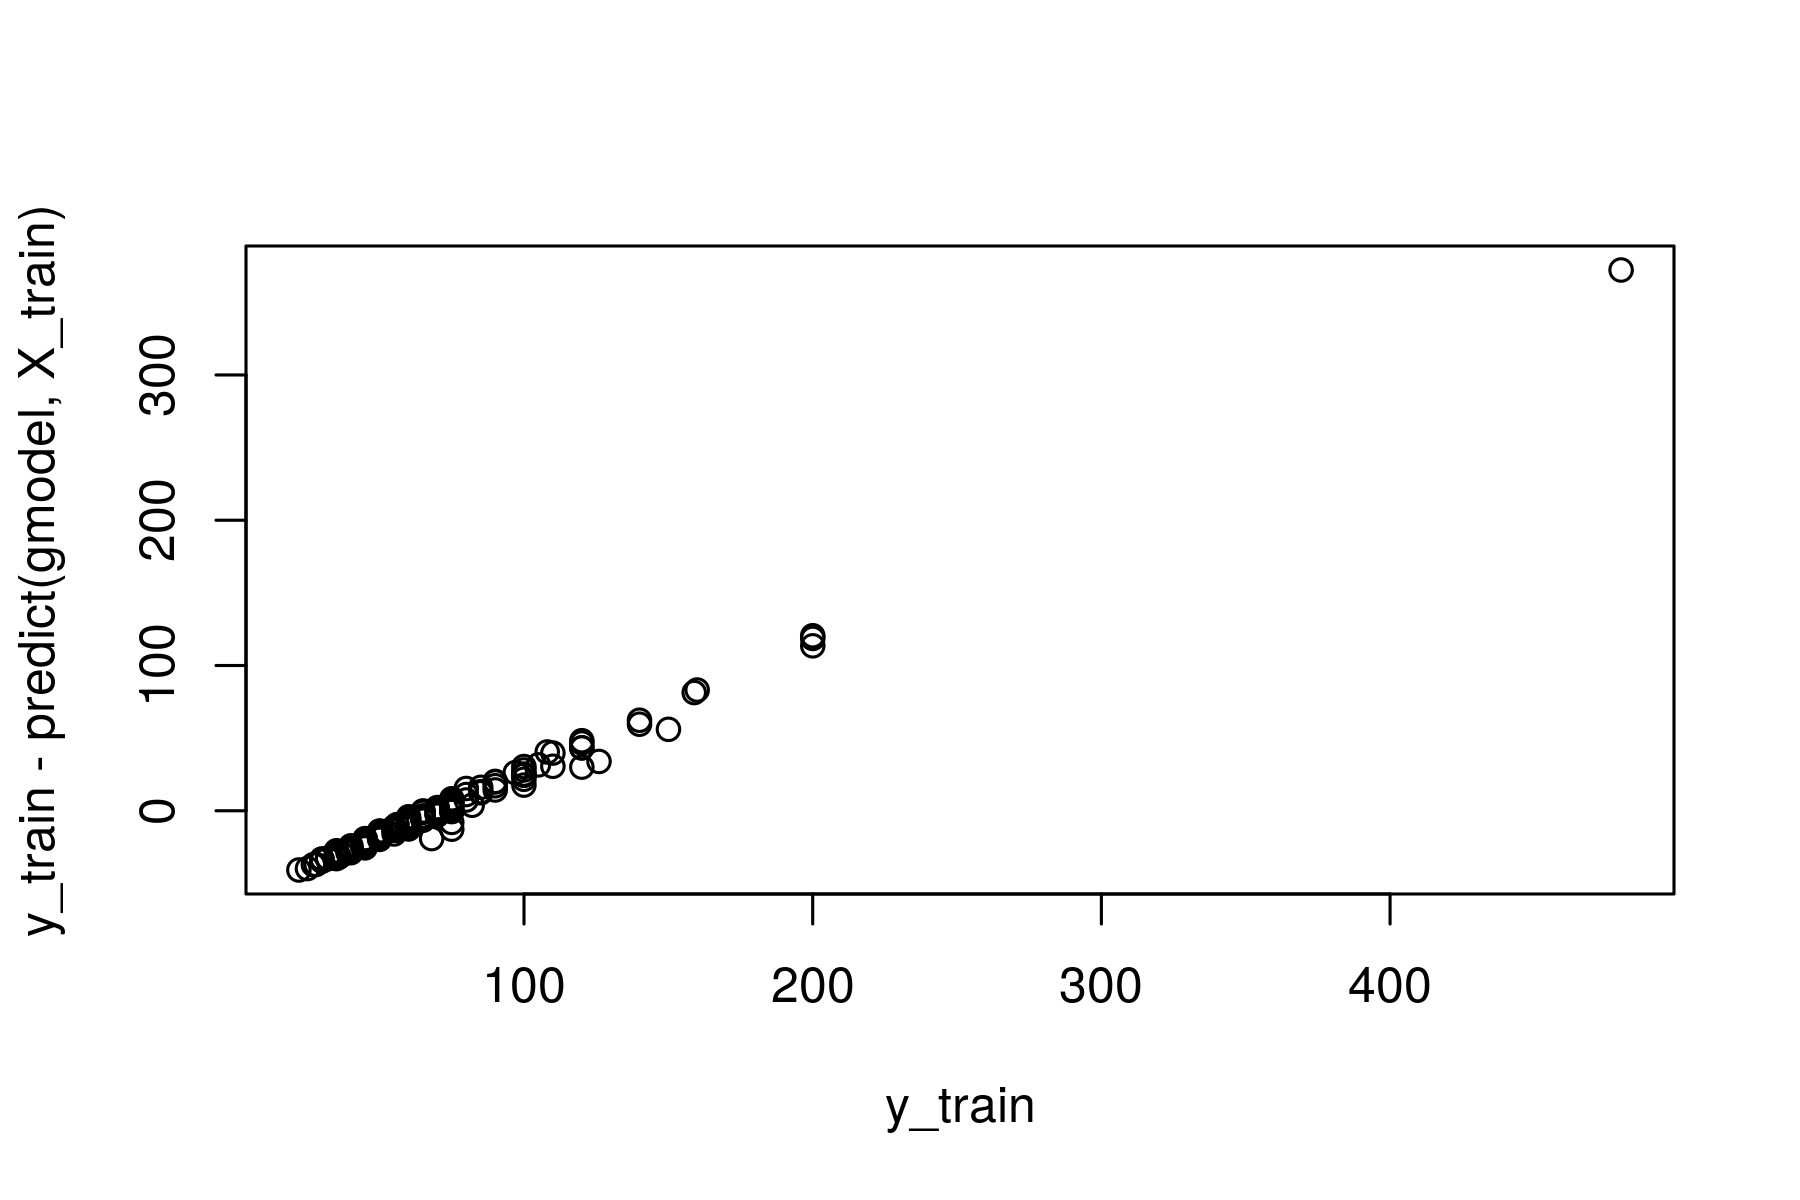

In [30]:
gmodel<-glmnet(X,y,alpha=0,lambda = cvfit$lambda.1se)
caret::postResample(predict(gmodel,X_train),obs = y_train)
caret::postResample(predict(gmodel,X_test),obs = y_test)
# Aunque nos sale un R^2 muy bueno si miramos los residuos nos daremos cuenta que nuestro modelo es bastante malo
# a Medida que aumenta el valor de los metros cuadrados el error crece de forma lineal.
plot(y_train,y_train-predict(gmodel,X_train))

RMSE   Rsquared        MAE 
30.3231990  0.6573665 17.5896889

RMSE   Rsquared        MAE 
18.2642045  0.6804646 14.0384816

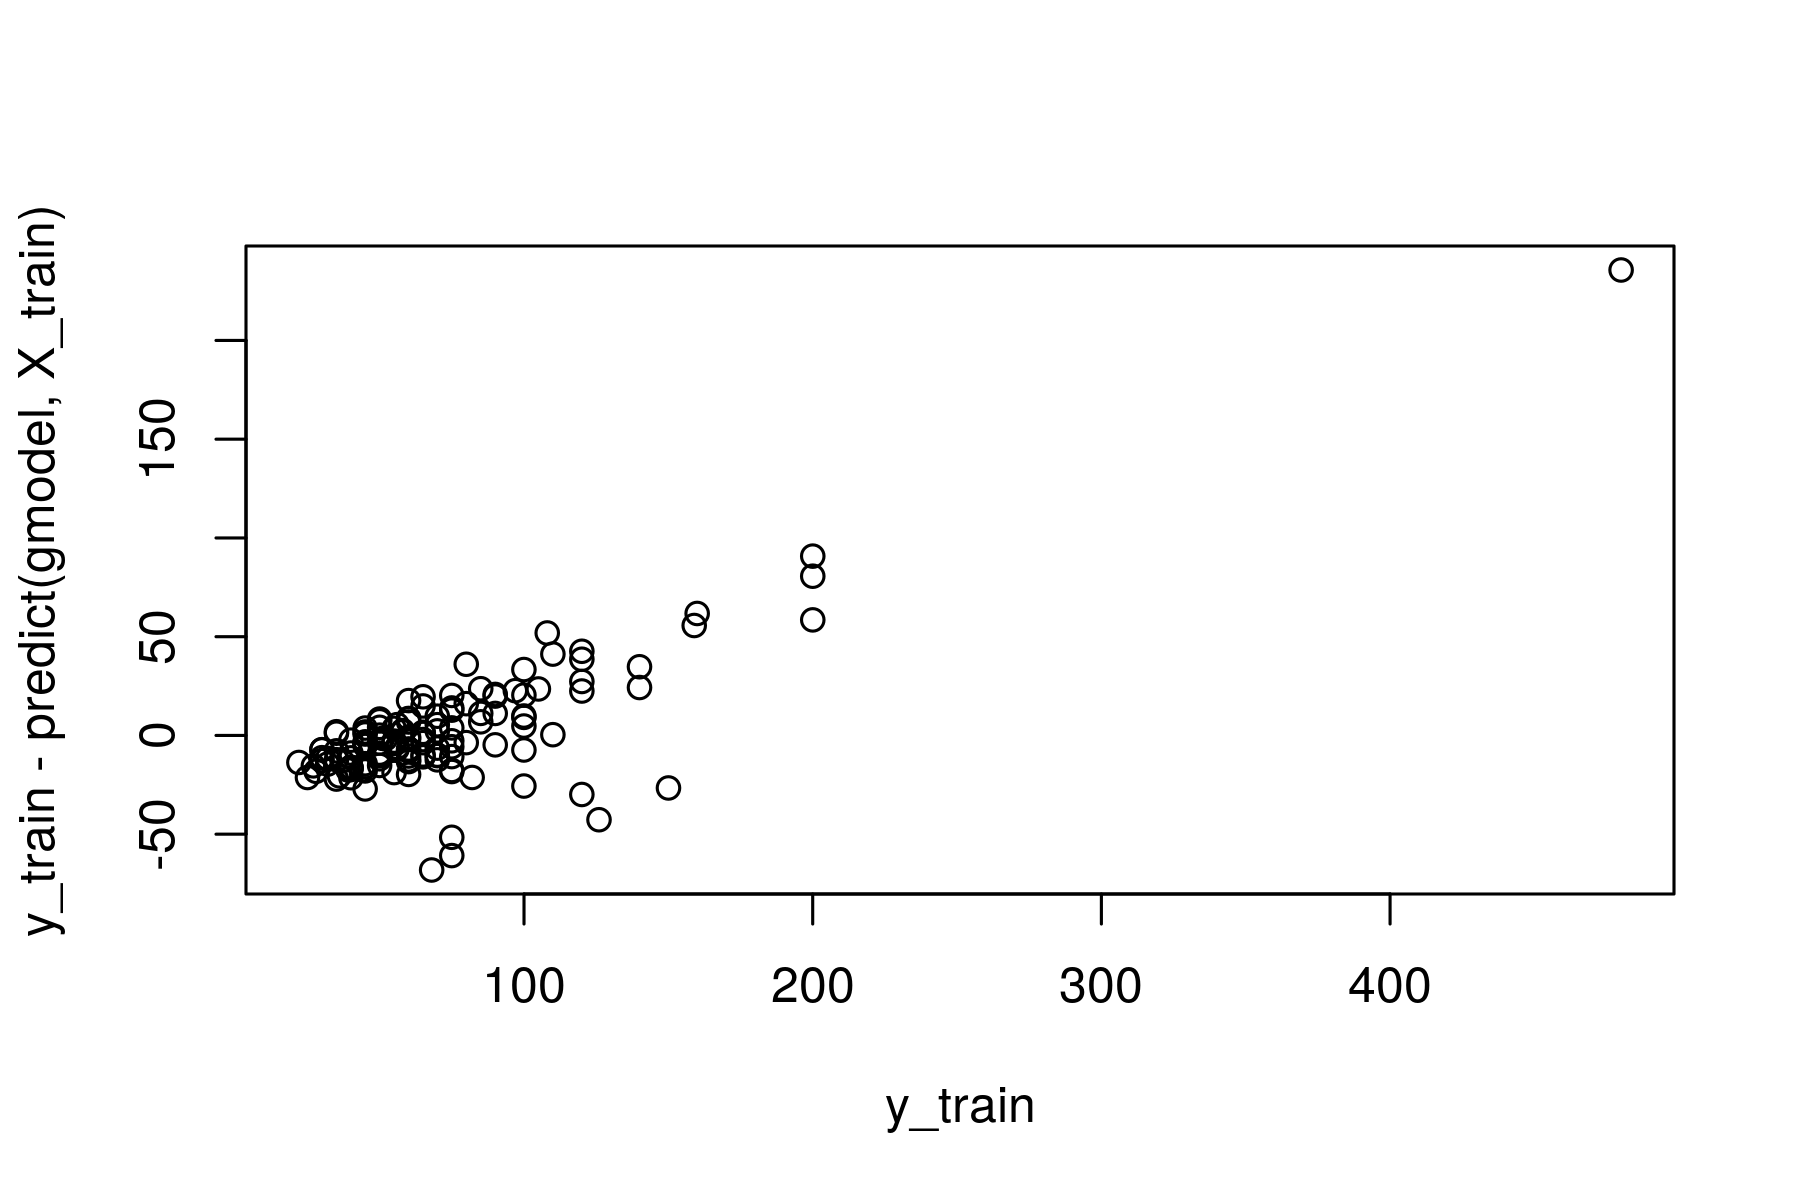

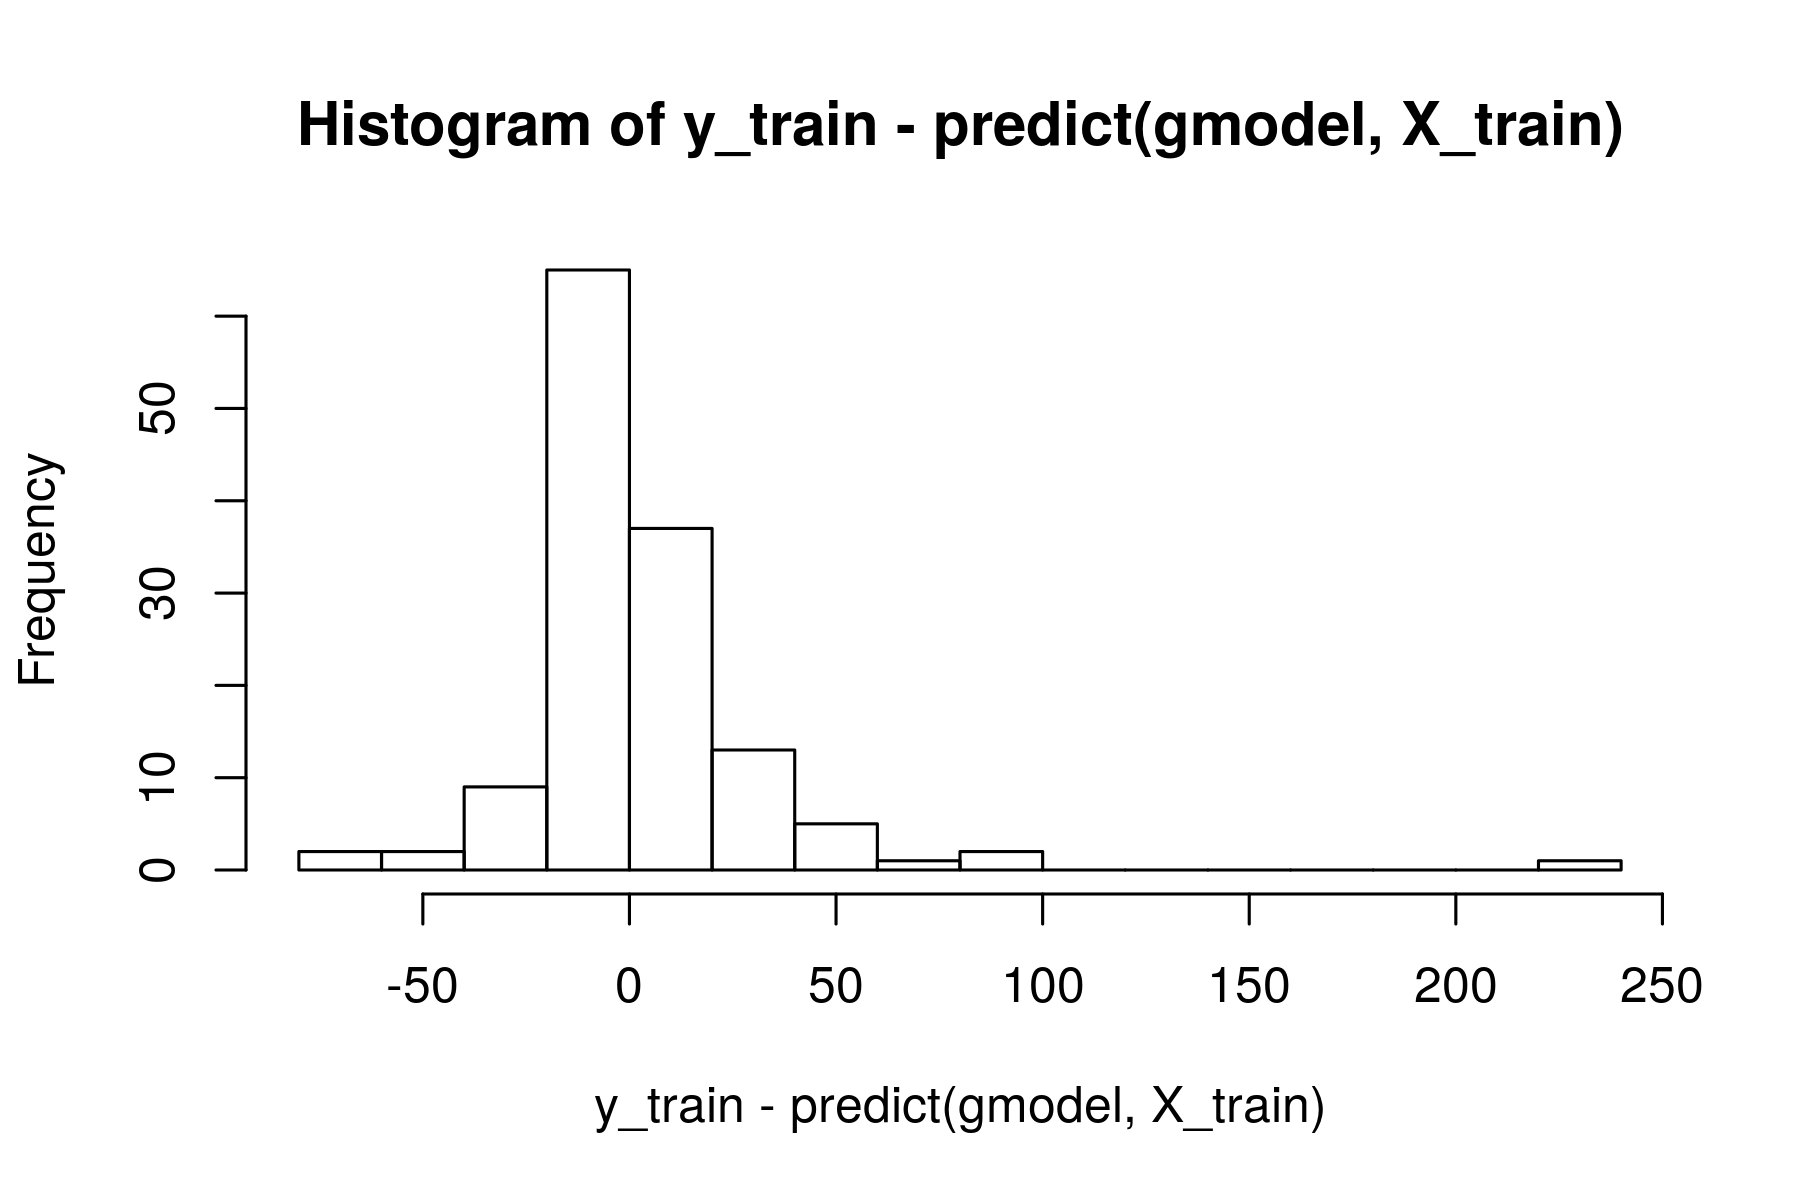

In [31]:
# Vamos a usar un valor más bajo de lambda:
gmodel<-glmnet(X,y,alpha=0,lambda = cvfit$lambda.min)
caret::postResample(predict(gmodel,X_train),obs = y_train)
caret::postResample(predict(gmodel,X_test),obs = y_test)
plot(y_train,y_train-predict(gmodel,X_train))
hist(y_train-predict(gmodel,X_train),breaks=20)

Después de todas las pruebas concluimos que el mejor modelo era el primero, el más sencillo como veremos más adelante comprobando sus residuos. 

Aunque con tan pocas muestras es dificil saber cual es el mejor modelo. Una regla buena es que en igualdad de condiciones, el modelo más sencillo suele ser el más fiable (navaja de Ockham). 

Mirad el histograma de los residuos sobre el conjunto de test para evaluar la calidad de vuestro modelo

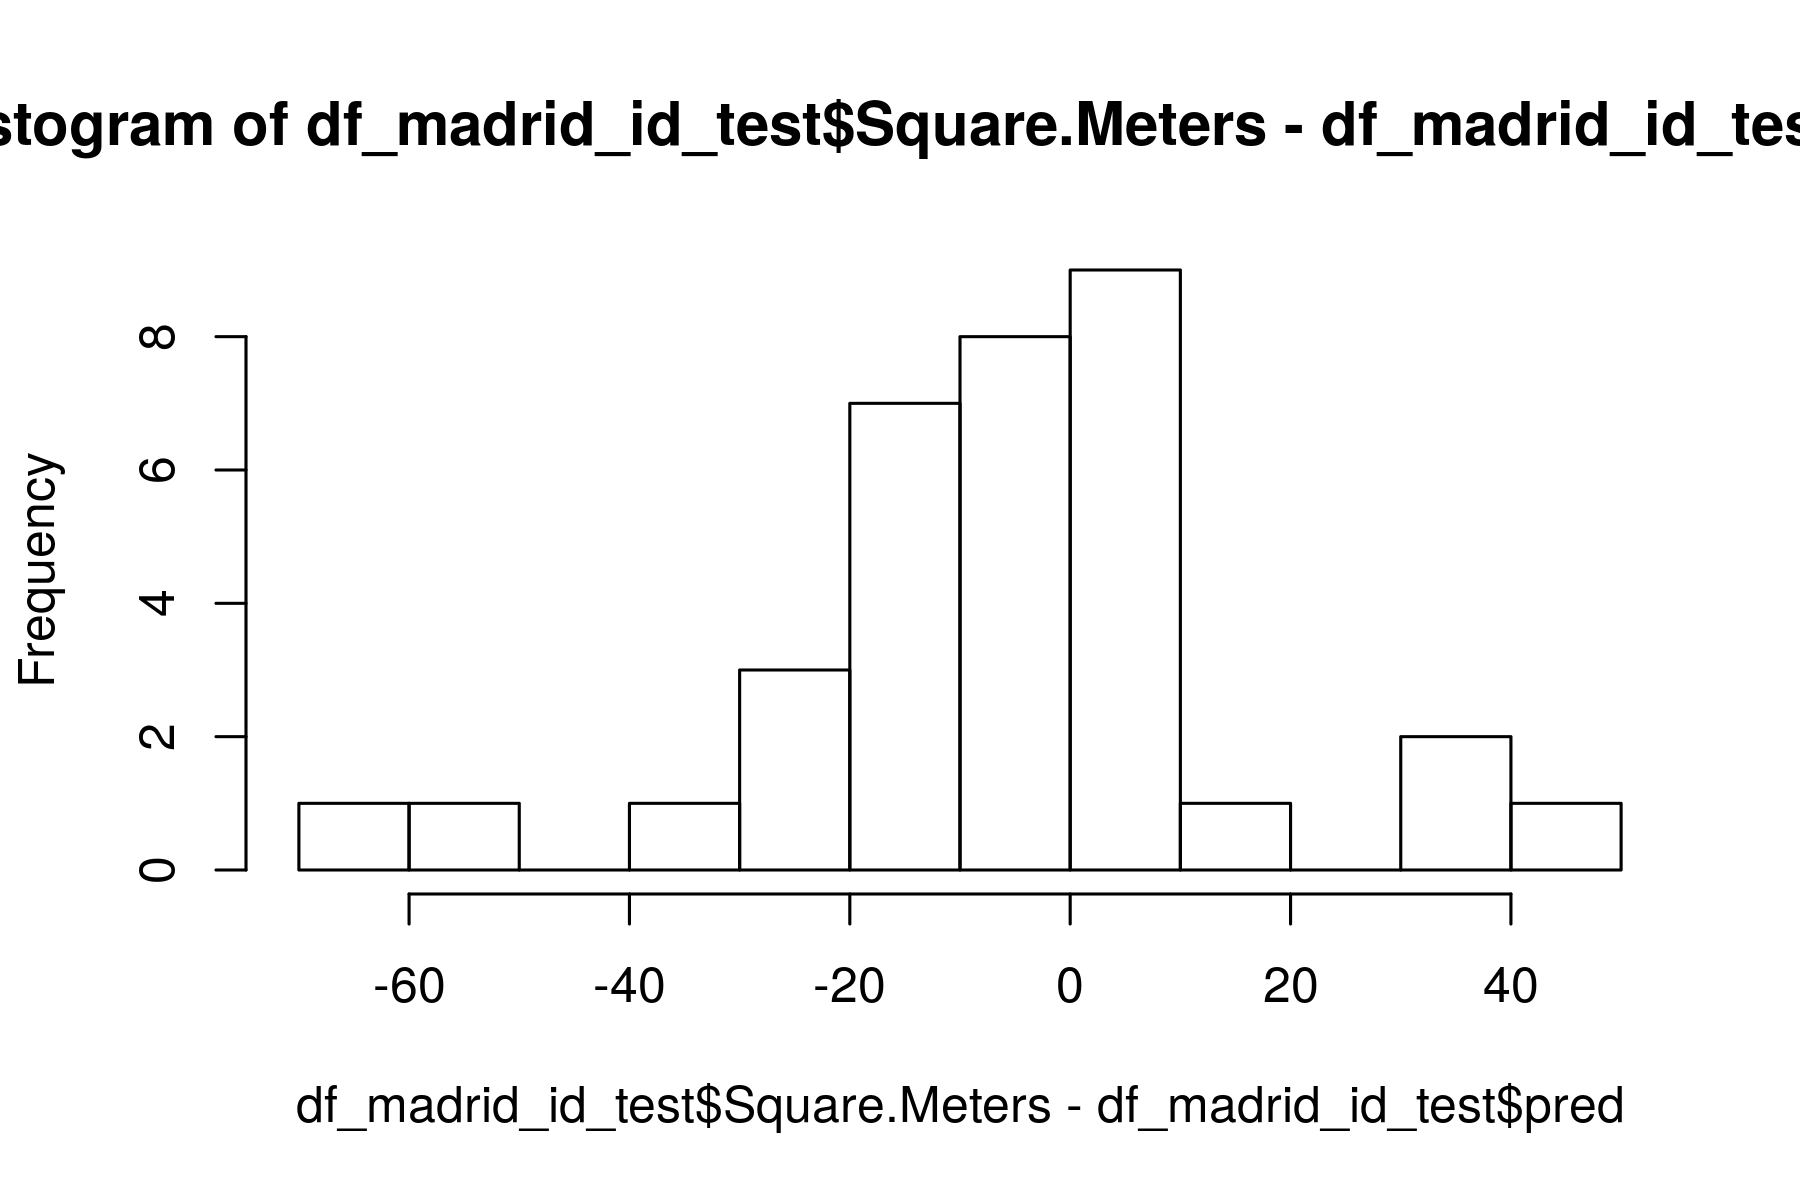

In [32]:
df_madrid_id_test$pred<-model %>% predict(df_madrid_id_test)
hist(df_madrid_id_test$Square.Meters-df_madrid_id_test$pred,breaks=15)


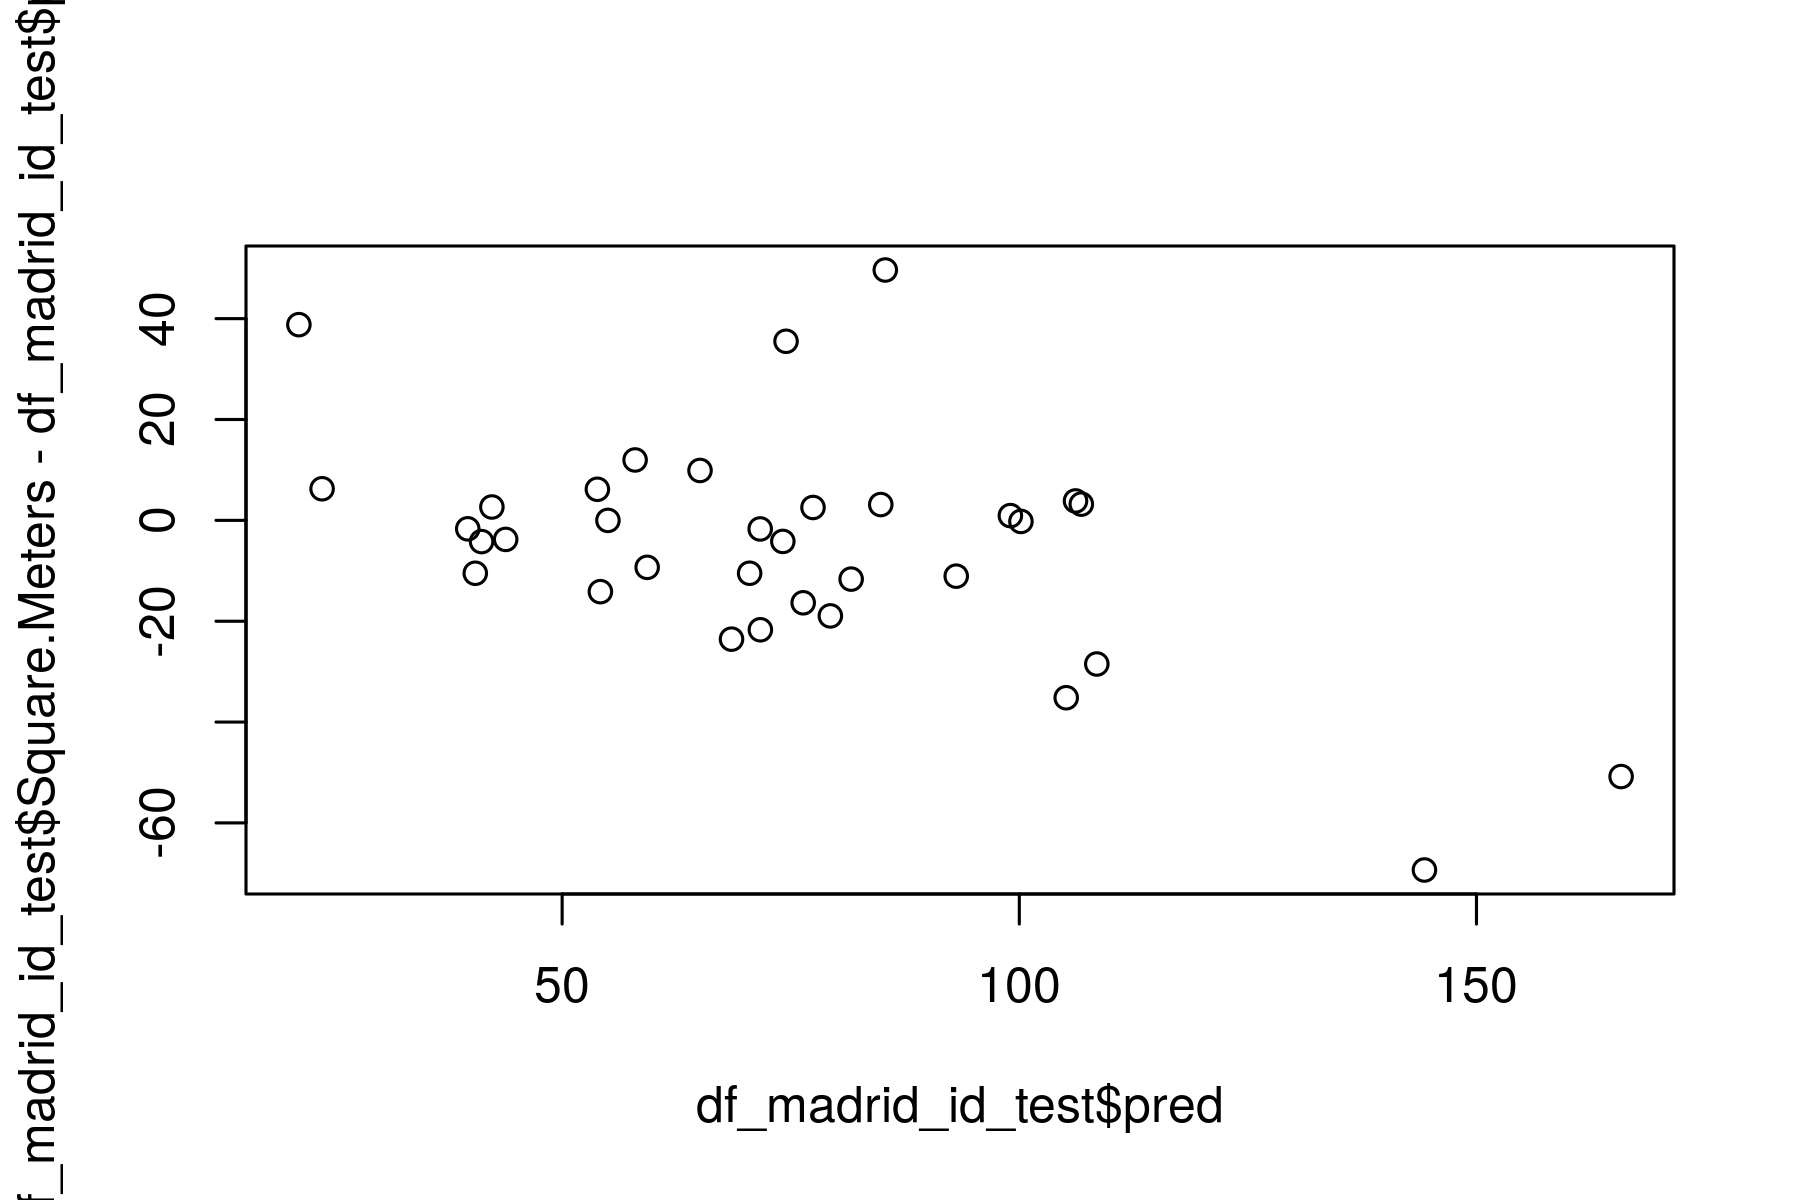

In [33]:
# Los residuos no siguen una distribución muy gaussiana, aunque con tan pocas muestras es dificil de verificarlo.
# Al menos su diagrama de dispersión si tiene buena pinta, no se ven tendencias:
plot(df_madrid_id_test$pred,df_madrid_id_test$Square.Meters-df_madrid_id_test$pred)

In [34]:
library(caret)
postResample(df_madrid_id_test$pred,obs = df_madrid_id_test$Square.Meters)

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




RMSE   Rsquared        MAE 
22.6933790  0.5020971 15.3498820

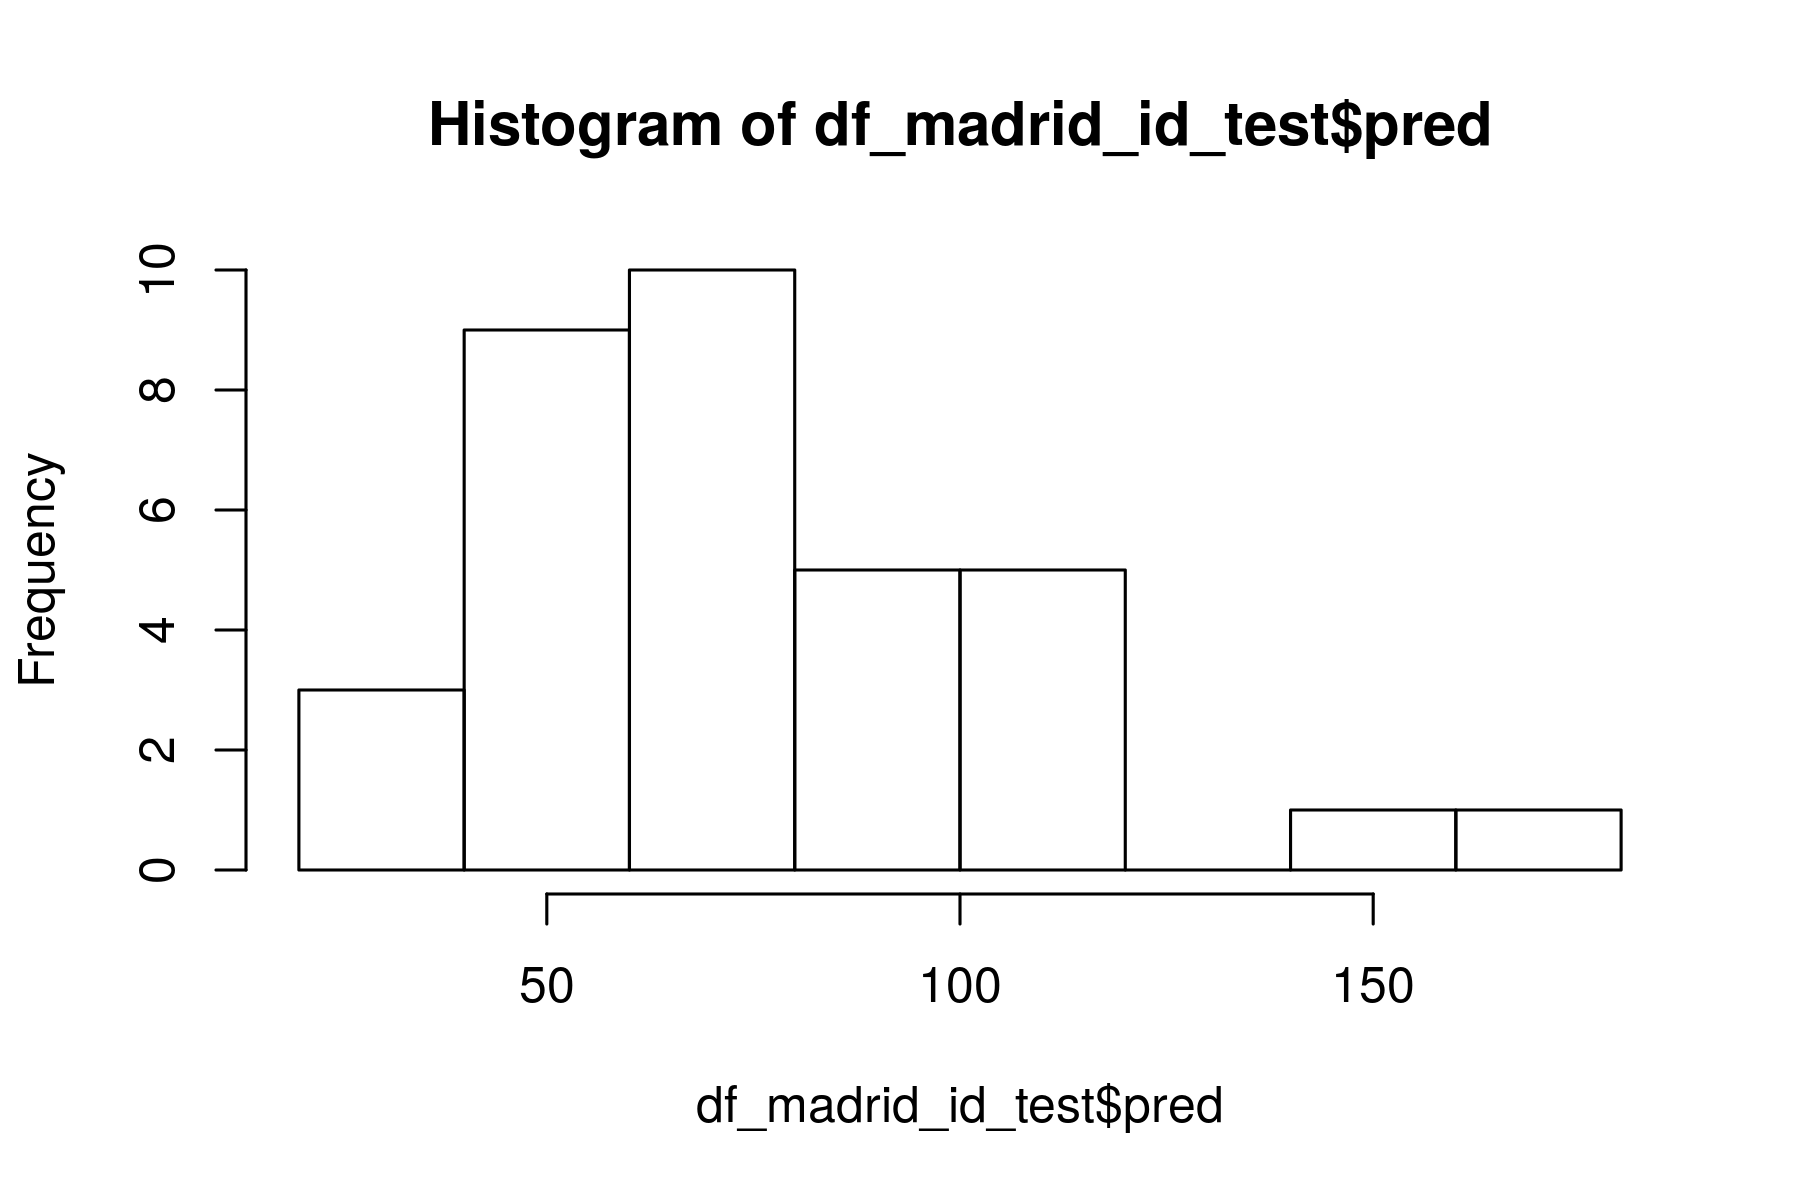

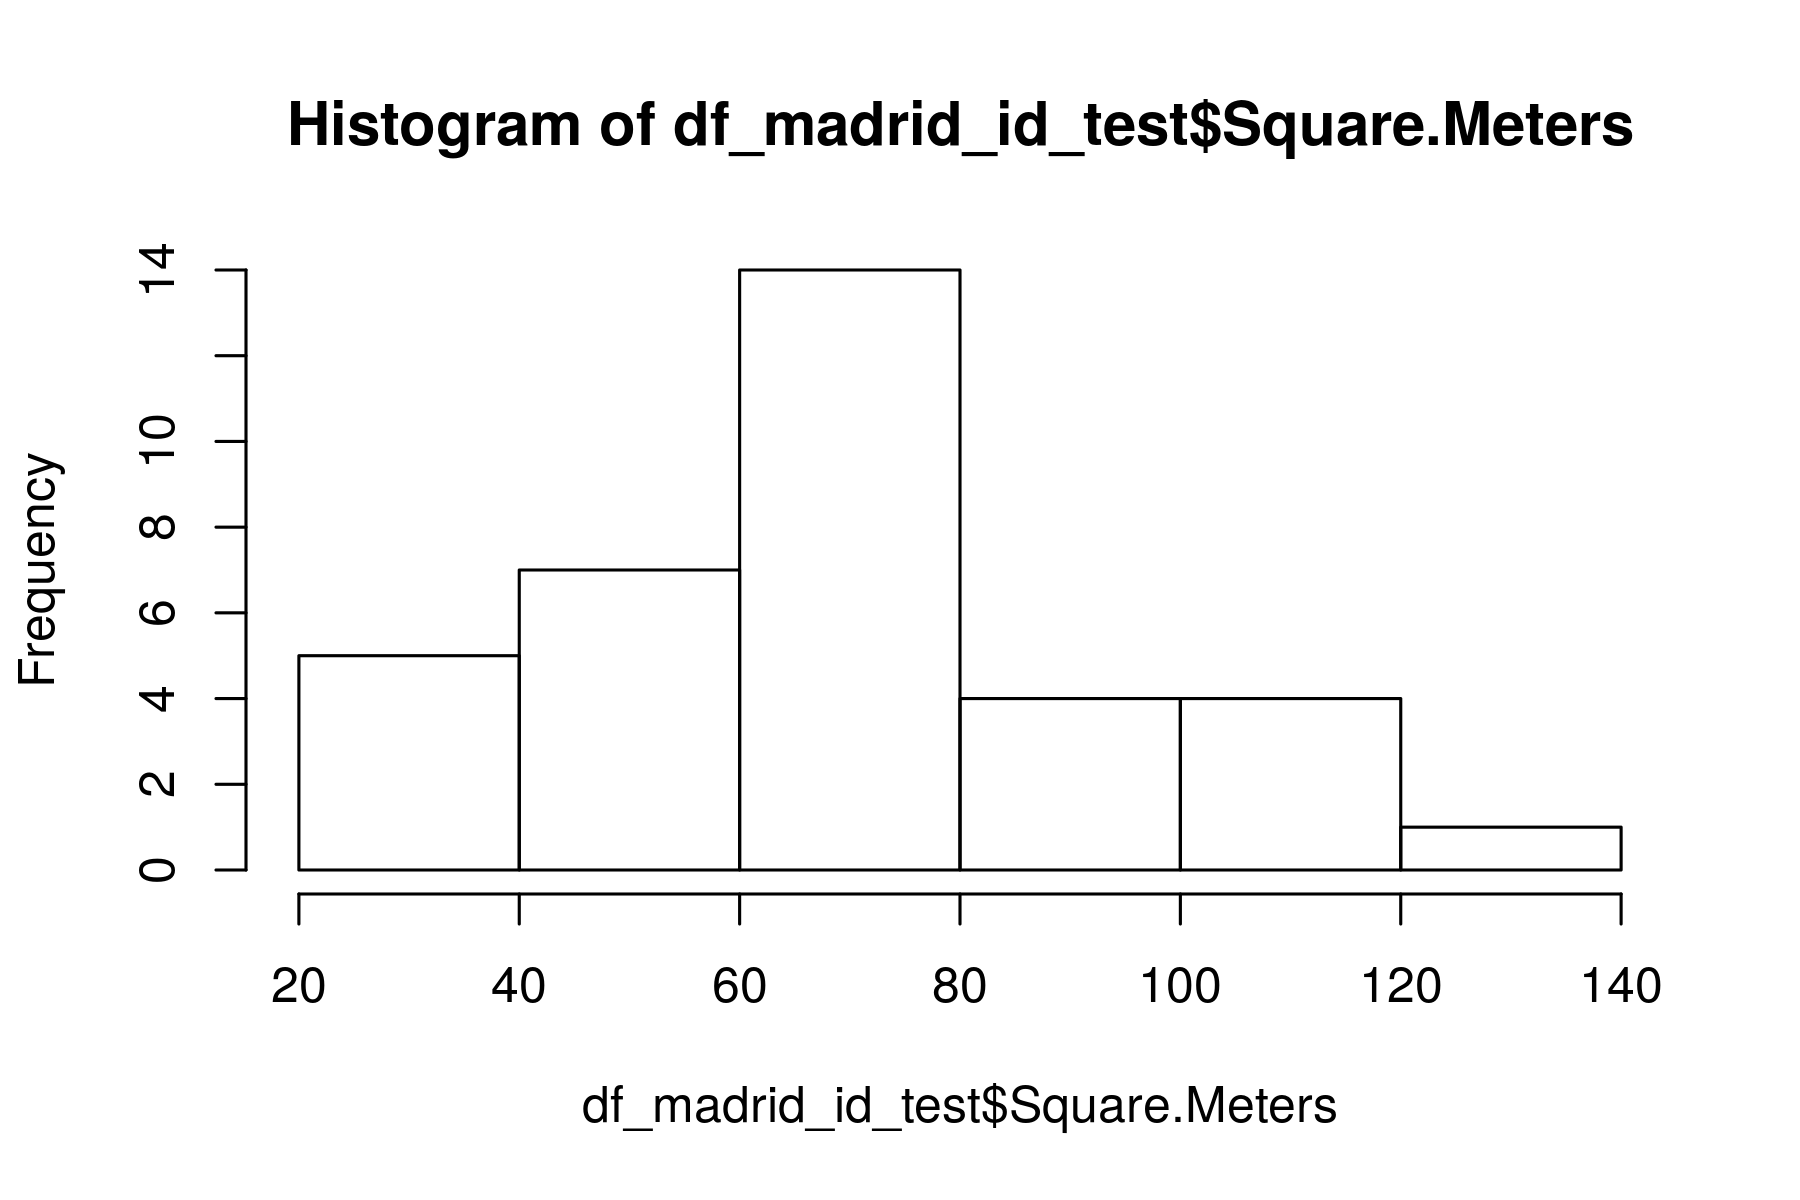

In [35]:
hist(df_madrid_id_test$pred)
hist(df_madrid_id_test$Square.Meters)

Si tuvieramos un anuncio de un apartamento para 6 personas (Accommodates) con un precio de 80€/noche y 3 habitaciones en el barrio de Sol.
¿Cuantos metros cuadrados tendría?
¿Como varía sus metros cuadrados con cada habitación adicional?

In [36]:
# Primero buscamos el neighb_id del barrio de Sol:
neighb_id_sol<-df_barrios %>% filter(names=="Sol") %>% select(neighb_id)
paste0("El id de barrio es:",neighb_id_sol)
# Luego creamos el dataframe:
df_appartment<-data.frame(neighb_id=neighb_id_sol,Bedrooms=3,Price=80,Accommodates=6)
# Por último damos la predicción
pred_m2<-predict(model,df_appartment)
paste("Los metros cuadrados son:",round(pred_m2))

[1] "El id de barrio es:7"

[1] "Los metros cuadrados son: 110"

In [37]:
cf<-coefficients(model)
cf_bedroom_sol<-cf['Bedrooms']

paste("En media cada habitación aumenta el tamaño del apartemos en:",round(cf_bedroom_sol,2),"m^2")


[1] "En media cada habitación aumenta el tamaño del apartemos en: 27.69 m^2"

Rellenar los Square.Meters con valor NA con el estimado con el modelo anterior.

In [38]:
df_madrid_id_all <- df_madrid %>% inner_join(df_barrios,by=c("Neighbourhood"='names')) 

df_madrid_id_all$Square.Meters[is.na(df_madrid_id_all$Square.Meters)]<-
 round(predict(model,df_madrid_id_all[is.na(df_madrid_id_all$Square.Meters),]))

head(df_madrid_id_all)

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id
,<fct>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>
1,Palacio,3,1,0,2,65,2,10,96,40.41706,-3.709482,25,Neighb_id_7
2,Palacio,5,2,2,3,100,4,25,97,40.41934,-3.709556,86,Neighb_id_7
3,Palacio,6,1,2,4,89,2,10,94,40.42113,-3.708628,84,Neighb_id_7
4,La Latina,4,1,1,2,49,2,20,89,40.41203,-3.709668,40,Neighb_id_4
5,La Latina,4,1,1,1,89,2,15,97,40.41205,-3.708516,46,Neighb_id_4
6,La Latina,2,1,1,1,61,1,0,95,40.41189,-3.712093,42,Neighb_id_4


Usar PCA para encontrar el apartamento más cercano a uno dado.

Este algoritmo nos ayudaría a dado un apartamento que el algoritmo nos devolvería los 5 apartamentos más similares.


Crearemos una función tal que le pasemos un apartamento con los siguientes datos:
* Accommodates	
* Bathrooms	
* Bedrooms	
* Beds	
* Price	
* Guests.Included	
* Extra.People	
* Review.Scores.Rating	
* Latitude	
* Longitude	
* Square.Meters

y nos devuelva los 5 más similares de:

In [39]:
df_madrid_pca<-na.omit(df_madrid_id_all[,c("Accommodates","Bathrooms","Bedrooms","Latitude","Longitude",
                                           "Beds","Price","Review.Scores.Rating","Square.Meters",'neighb_id')])

# Aunque podríamos dividir los datos entre test y training, aquí realmente no estamos tratando de hacer una 
# predicción, sino tratando de encontrar en el mismo dataset los elementos más similares.
pca_df<-prcomp(df_madrid_pca %>% select(-neighb_id),center = TRUE, scale. = TRUE)

In [40]:
summary(df_madrid_pca)

  Accommodates      Bathrooms        Bedrooms        Latitude    
 Min.   : 1.000   Min.   :0.000   Min.   :0.000   Min.   :40.33  
 1st Qu.: 3.000   1st Qu.:1.000   1st Qu.:1.000   1st Qu.:40.41  
 Median : 4.000   Median :1.000   Median :1.000   Median :40.42  
 Mean   : 4.141   Mean   :1.244   Mean   :1.446   Mean   :40.42  
 3rd Qu.: 5.000   3rd Qu.:1.000   3rd Qu.:2.000   3rd Qu.:40.43  
 Max.   :16.000   Max.   :6.000   Max.   :8.000   Max.   :40.51  
                                                                 
   Longitude           Beds           Price        Review.Scores.Rating
 Min.   :-3.835   Min.   : 1.00   Min.   : 10.00   Min.   : 20.00      
 1st Qu.:-3.707   1st Qu.: 1.00   1st Qu.: 55.00   1st Qu.: 88.00      
 Median :-3.702   Median : 2.00   Median : 70.00   Median : 93.00      
 Mean   :-3.699   Mean   : 2.41   Mean   : 85.61   Mean   : 91.31      
 3rd Qu.:-3.696   3rd Qu.: 3.00   3rd Qu.: 98.00   3rd Qu.: 97.00      
 Max.   :-3.576   Max.   :16.00   Max.  

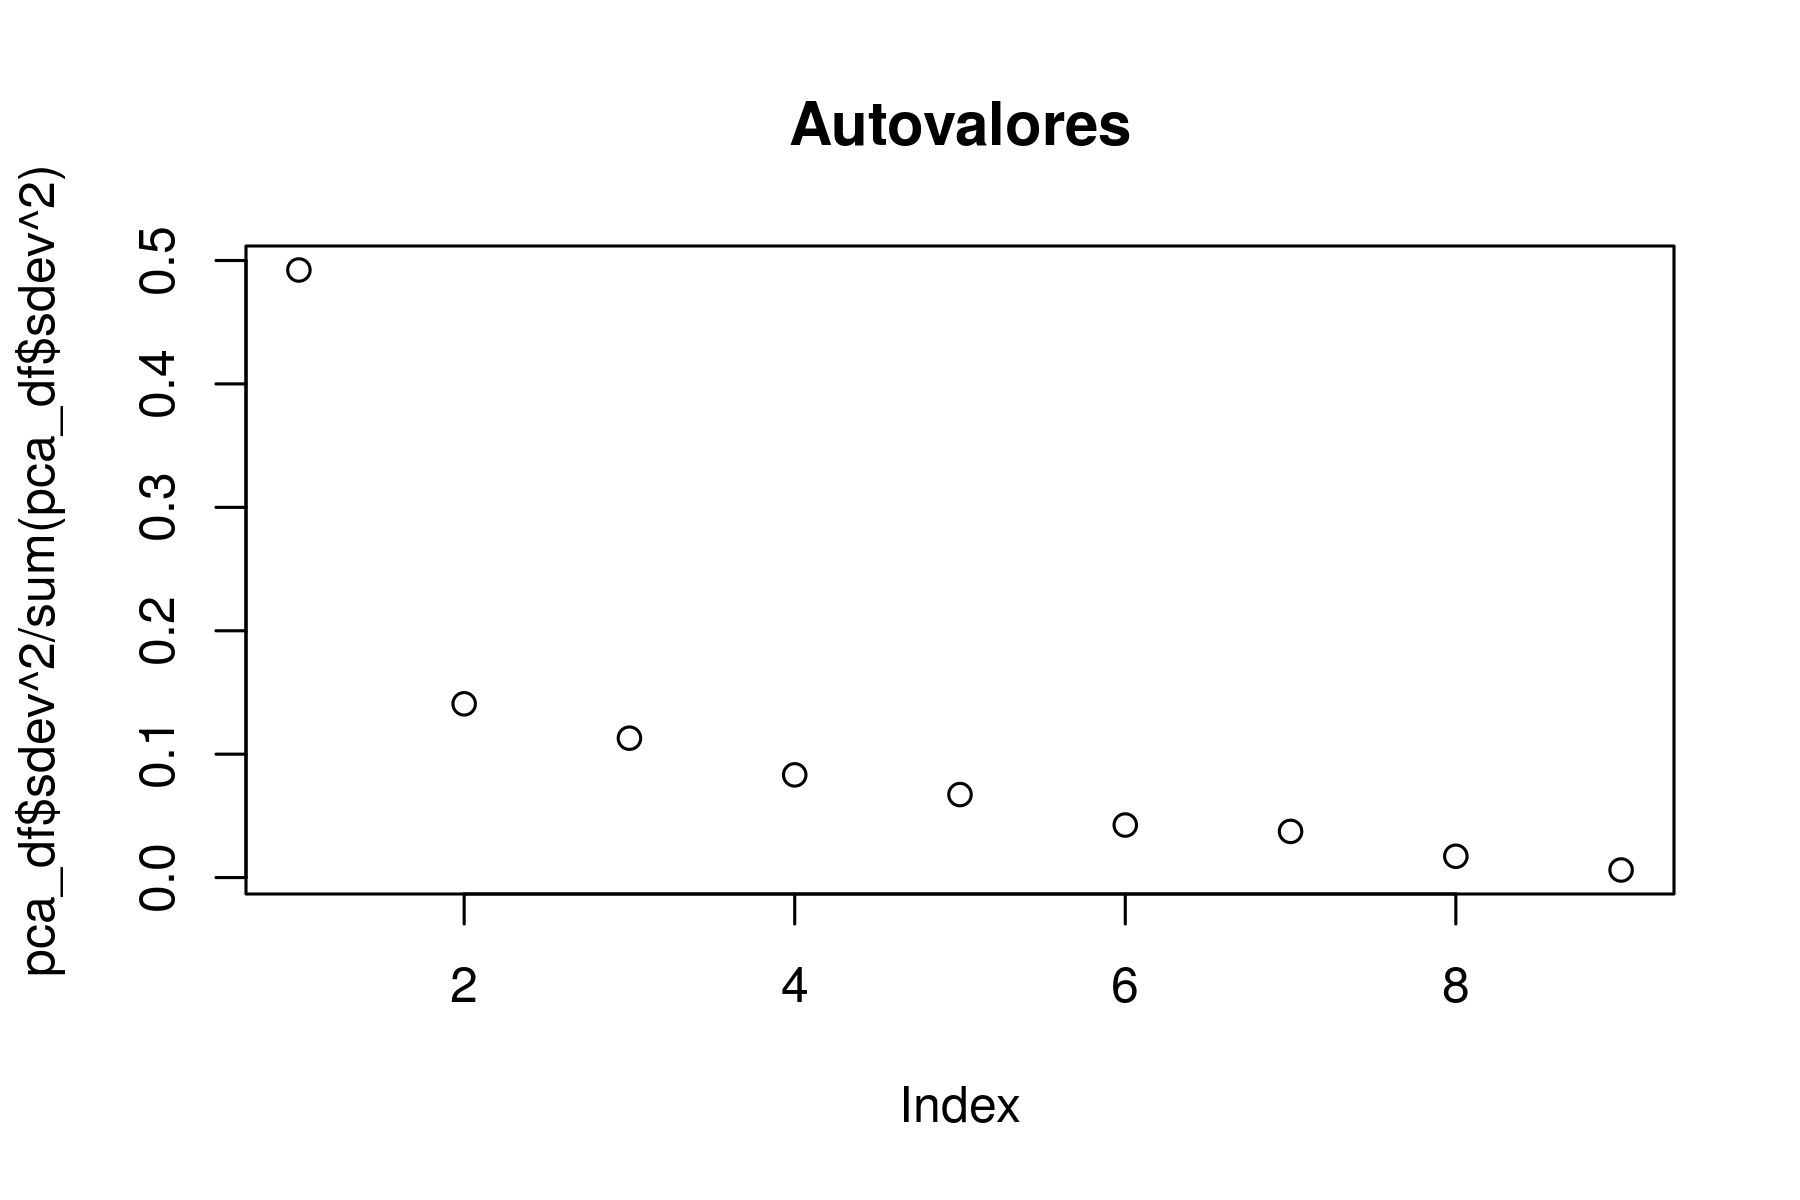

In [41]:
plot(pca_df$sdev^2/sum(pca_df$sdev^2),main="Autovalores")

In [42]:
str(pca_df)

List of 5
 $ sdev    : num [1:9] 2.105 1.126 1.008 0.865 0.778 ...
 $ rotation: num [1:9, 1:9] 0.416 0.3757 0.4298 0.0325 0.0327 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:9] "Accommodates" "Bathrooms" "Bedrooms" "Latitude" ...
  .. ..$ : chr [1:9] "PC1" "PC2" "PC3" "PC4" ...
 $ center  : Named num [1:9] 4.14 1.24 1.45 40.42 -3.7 ...
  ..- attr(*, "names")= chr [1:9] "Accommodates" "Bathrooms" "Bedrooms" "Latitude" ...
 $ scale   : Named num [1:9] 1.9106 0.516 0.9611 0.016 0.0175 ...
  ..- attr(*, "names")= chr [1:9] "Accommodates" "Bathrooms" "Bedrooms" "Latitude" ...
 $ x       : num [1:4746, 1:9] -1.84 1.51 1.16 -1.13 -1.01 ...
  ..- attr(*, "dimnames")=List of 2
  .. ..$ : chr [1:4746] "1" "2" "3" "4" ...
  .. ..$ : chr [1:9] "PC1" "PC2" "PC3" "PC4" ...
 - attr(*, "class")= chr "prcomp"


In [43]:
get_closest_element<-function(pca_df, new_flat,num_flats){
    pca_new<-predict(pca_df,newdata = new_vector)
    pca_orig<-pca_df$x[,1:2]
    pca_new <-pca_new[,1:2]

    idx<-order(rowSums((pca_new-pca_orig)^2))
    df_madrid_pca[idx %in% 1:num_flats,]
}

In [44]:
new_vector<-(df_madrid_pca %>% select(-neighb_id))[10,]
new_vector
get_closest_element(pca_df,new_vector,5)

,Accommodates,Bathrooms,Bedrooms,Latitude,Longitude,Beds,Price,Review.Scores.Rating,Square.Meters
,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>
11,2,1,1,40.42101,-3.707141,1,105,100,59


,Accommodates,Bathrooms,Bedrooms,Latitude,Longitude,Beds,Price,Review.Scores.Rating,Square.Meters,neighb_id
,<int>,<dbl>,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<dbl>,<fct>
165,7,3.0,4,40.42807,-3.694460,4,230,93,186,Neighb_id_1
1284,8,2.5,3,40.42007,-3.706785,3,170,92,125,Neighb_id_7
1462,5,1.0,2,40.40854,-3.703927,3,80,90,72,Neighb_id_4
3283,3,1.0,0,40.43723,-3.702764,2,42,80,21,Neighb_id_5
4025,3,1.0,0,40.41167,-3.701486,2,50,93,12,Neighb_id_4


Bonus: ¿de todas las coordenadas PCA cual es la que mejor permite clasificar por id de barrio?

¿Por qué?

In [45]:
pca_x_neighb<-cbind(data.frame(pca_df$x),neighb_id=df_madrid_pca$neighb_id)
pca_cols<-colnames(pca_x_neighb)[1:ncol(pca_x_neighb)-1]
df_F_val<-data.frame(pca=pca_cols,F=NA)
for (idx in (1:nrow(df_F_val))){
    formula<-paste(pca_cols[idx],"~ neighb_id")
    df_F_val$F[idx]<-oneway.test(pca_x_neighb,formula = as.formula(formula))$statistic
}
df_F_val

pca,F
<fct>,<dbl>
PC1,23.303847
PC2,236.867655
PC3,6.896276
PC4,55.355142
PC5,13.620589
PC6,37.085937
PC7,15.462461
PC8,1.649254
PC9,767.067140


Parece que PC2 y PC9 son los que más varían a la hora de elegir por id de barrio. Vamos a analizar porqué.

Loading required package: magrittr


Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




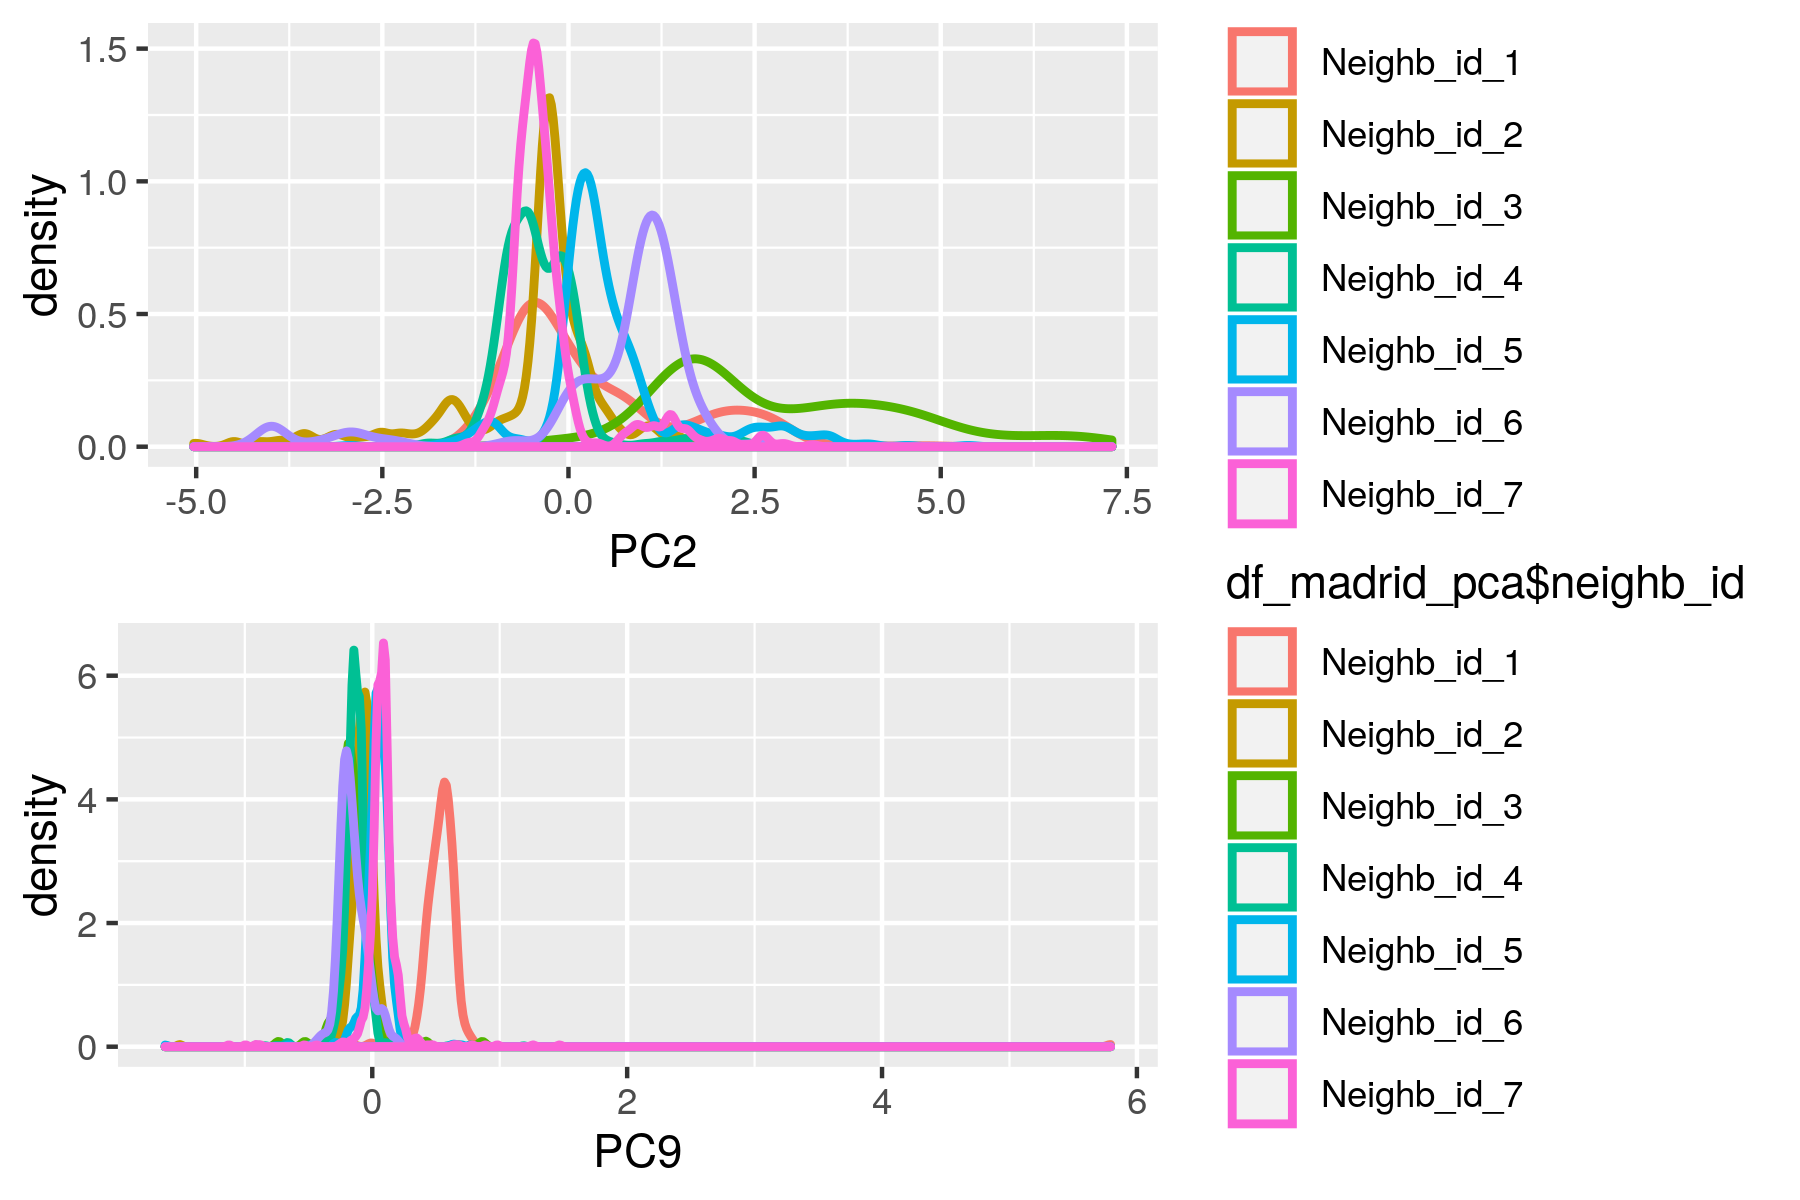

In [46]:
library(ggpubr)
g1<-ggplot(data.frame(pca_df$x),aes(x=PC2,color=df_madrid_pca$neighb_id))+geom_density(size=1)
g2<-ggplot(data.frame(pca_df$x),aes(x=PC9,color=df_madrid_pca$neighb_id))+geom_density(size=1)

ggarrange(g1,g2,ncol=1)

In [47]:
pca_df$rotation
# Vemos como la contribución principal a PC2 es la latitud y longitud, por eso parece permitir identificar barrios
# Curiosamente PC9 se enfoca en dormitorios y tamaño del apartamento. Pero es el autovector con un autovalor con menor peso.

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Accommodates,0.41603385,-0.085725856,0.12006600,-0.11933489,0.30811102,-0.34864784,0.170362195,0.737185665,0.044232951
Bathrooms,0.37574356,0.033797144,-0.09014333,0.11275575,-0.49355386,-0.41420304,-0.649172061,-0.014377757,-0.006648125
Bedrooms,0.42983854,-0.014388916,0.04619019,-0.07111012,0.20975832,0.51820435,-0.253942371,-0.007810005,-0.656322775
Latitude,0.03251900,0.708520696,0.01977654,0.64907428,0.26037256,-0.07107345,0.013009322,0.022929039,-0.041377733
Longitude,0.03274019,0.686430790,-0.16813744,-0.68977064,-0.13965599,0.01216353,0.055908214,0.027535983,0.012304993
Beds,0.40770246,-0.048282676,0.09054734,-0.14842942,0.38741048,-0.40884352,0.176001082,-0.672318965,0.031437214
Price,0.36939767,-0.007070586,-0.11451985,0.20453878,-0.57188563,0.05696653,0.665956221,-0.034475117,-0.183193544
Review.Scores.Rating,0.03221412,-0.123404262,-0.96187626,0.06734004,0.22936708,-0.02228713,-0.003381081,0.029078363,0.005482947
Square.Meters,0.44173335,0.022431248,0.01199741,0.05005632,0.02065574,0.51210396,-0.085353141,-0.030963410,0.728558781


Otra forma de obtener lo mismo con LDA

In [48]:
MASS::lda(formula=neighb_id~.,data=pca_x_neighb)

Call:
lda(neighb_id ~ ., data = pca_x_neighb)

Prior probabilities of groups:
Neighb_id_1 Neighb_id_2 Neighb_id_3 Neighb_id_4 Neighb_id_5 Neighb_id_6 
 0.09018121  0.13190055  0.03666245  0.36978508  0.15971344  0.03729456 
Neighb_id_7 
 0.17446271 

Group means:
                    PC1        PC2         PC3         PC4         PC5
Neighb_id_1  0.47396839  0.3123846  0.11360572  0.26799952  0.08850773
Neighb_id_2  0.07306481 -0.5281200  0.10375946 -0.15856727 -0.07414055
Neighb_id_3  0.43573155  2.8673132 -0.28694090 -0.31216962  0.30848971
Neighb_id_4 -0.41649085 -0.3586377  0.01165326  0.02088992  0.06272357
Neighb_id_5  0.16913973  0.5797692 -0.02259955  0.12880191 -0.07784220
Neighb_id_6  0.39818255  0.5603157 -0.31429389 -1.34198646 -0.29069727
Neighb_id_7  0.25101556 -0.2551229 -0.01369559  0.17163620 -0.05406835
                     PC6           PC7          PC8         PC9
Neighb_id_1  0.389213130 -0.2098551258 -0.042022893  0.54054869
Neighb_id_2 -0.087856546 -0.0113968310 -

Si nos fijamos en los coeficiente, en "Proportion of trace" vemos que con los dos primeros componentes LD1 y LD2 son los más importantes para clasificar por neighb_id.
Y si miramos los coeficientes que más importancia tienen en LD1 y LD2 son a su vez PC2 y PC9 como habíamos visto antes con el test ANOVA.